# 개인대출 부도분석 및 예측모델링  (JB우리캐피탈_Jbeat!팀)

## * 분석 목차

<b>1. 데이터 탐색(EDA) 및 전처리</b>
   - 1-1. 전체적인 데이터 탐색
   - 1-2. 컬럼 type별 분포 확인 및 데이터 1차 처리 
   - 1-3. 데이터 상세 탐색
   - 1-4. 데이터 결측값 대체(다중대체, 차원축소, 클러스터링)<br>

<b>2. Feature Engineering</b>
   - 2-1. train data, test data 구분 (scailing X)
   - 2-2. train data, test data 구분 (scailing O)
   - 2-3. 클래스 불균형 해소 <br>

<b>3. 데이터 모델링</b>
   - 3-1. XGBoost - 최종선택
   - 3-2. Random Forest
   - 3-3. Logistic Regression<br>

<b>4. 최종 Hidden Data set에 모델 적용 </b>
   - 4-1. 함수 생성
   - 4-2. 데이터 불러오기
   - 4-3. 전처리 및 모델링 <br>

## * Library 

In [1]:
import numpy as np
import pandas as pd
import time
from datetime import datetime

import missingno as msno
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Normalizer, MinMaxScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.decomposition import PCA, TruncatedSVD

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, GridSearchCV

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, roc_auc_score, make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, cohen_kappa_score
from sklearn.model_selection import learning_curve
import shap

In [2]:
import warnings
warnings.filterwarnings('ignore')

## [함수 사전 정의]

In [3]:
# 숫자로 된 범주형 변수의 타입 변경
def type_change(df):
    
    df['CNT_CHILDREN'] =df['CNT_CHILDREN'].astype(object)
    df['FLAG_MOBIL'] = df['FLAG_MOBIL'].astype(object)
    df['FLAG_EMP_PHONE'] = df['FLAG_EMP_PHONE'].astype(object)
    df['FLAG_WORK_PHONE'] = df['FLAG_WORK_PHONE'].astype(object)
    df['FLAG_PHONE'] = df['FLAG_PHONE'].astype(object)
    df['FLAG_EMAIL'] = df['FLAG_EMAIL'].astype(object)
    df['REGION_RATING_CLIENT'] = df['REGION_RATING_CLIENT'].astype(object)
    df['HOUR_APPR_PROCESS_START'] = df['HOUR_APPR_PROCESS_START'].astype(object)
    df['REG_CITY_NOT_LIVE_CITY'] = df['REG_CITY_NOT_LIVE_CITY'].astype(object)
    df['REG_CITY_NOT_WORK_CITY'] = df['REG_CITY_NOT_WORK_CITY'].astype(object)
    df['LIVE_CITY_NOT_WORK_CITY'] = df['LIVE_CITY_NOT_WORK_CITY'].astype(object)
    df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].astype(object)
    df['FLAG_DOCUMENT_2'] = df['FLAG_DOCUMENT_2'].astype(object)
    df['FLAG_DOCUMENT_3'] = df['FLAG_DOCUMENT_3'].astype(object)
    df['FLAG_DOCUMENT_4'] = df['FLAG_DOCUMENT_4'].astype(object)
    

#컬럼명 소문자로 변경
def col_to_lower(df):
    df.columns = df.columns.str.lower()
    
    
# 모든 값이 음수인 연속형 변수를 양수값으로 변경하고 365로 나눈 후 몫을 구해주는 함수
def transform_and_divide_continuous_variable(df, col_name):
    new_col_name = f'{col_name}_y' #positive
    df[new_col_name] = (-1) * df[col_name] // 365

    
def numeric_outlier(df, col_name):
    #소득금액 이상값을 boxplot maximum 값으로 변경하기
    Q1_INCOME = df[col_name].describe()['25%']
    Q3_INCOME = df[col_name].describe()['75%']
    IQR_INCOME = Q3_INCOME-Q1_INCOME
    BP_MAX = Q3_INCOME + 1.5*IQR_INCOME
    
    # 'amt_income_total_outlier' 컬럼 생성 (조건에 따라 직접 설정)
    # 박스플랏의 maximum 값보다 큰 값들은 모두 박스플랏의 maximum값으로 변경
    new_col_name = col_name + '_outlier'
    df[new_col_name] = df[col_name]  
    df.loc[df[col_name] >= BP_MAX , new_col_name] = BP_MAX 
    
    
# days, year 이상치 처리
def day_outlier(df, day=True):    
    if day:
        filtered_columns = [col for col in df.columns if col.startswith('days')]
        for col in filtered_columns:
            df[col] = df[col].apply(lambda x: 1 if x > 0 else x)
    else:
        filtered_columns = [col for col in df.columns if col.startswith('year')]
        for col in filtered_columns:
            df[col] = df[col].apply(lambda x: -1 if x < 0 else x)

            
def cat_null(df, col_name):
    #XNA가 있을 경우
    df[col_name].replace('XNA', 'Null', inplace=True)
    
    # NULL 값을 'NULL'로 대체
    df[col_name].fillna('Null', inplace=True)
    
    
# one-hot encoding
def ohe(df, col) :
    if type(col) == str:
        df = pd.get_dummies(df, columns = [col])
    else:
        df = pd.get_dummies(df, columns = col)
    return df

## [데이터 분석 코드]

## 1. 데이터 탐색(EDA) 및 전처리 

### 1-1. 전체적인 데이터 탐색

#### 1) 대출 고객, 컬럼 개수 파악 

In [4]:
#데이터 불러오기
df = pd.read_csv('../0.data/loan_customer.csv')

In [5]:
df.shape

(24000, 35)

➡ 데이터는 24,000건의 대출의 35개 컬럼으로 구성되어 있음

In [6]:
pd.set_option('display.max_columns', None)   #모든 열을 출력

df.head(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,CB_SCORE_1,CB_SCORE_2,CB_SCORE_3,TARGET
0,100002,Cash loans,M,Y,0,202500.0,NaN,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461.0,-637.0,-3648.0,-2120.0,1,1,0,1,0,2,WEDNESDAY,10,0,0,0,Business Entity Type 3,0,1,0,NaN,NaN,58.349224,1
1,100004,Revolving loans,NaN,NaN,0,67500.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,NaN,-19046.0,NaN,-4260.0,-2531.0,1,1,1,1,0,2,MONDAY,9,0,0,0,Government,0,0,0,26.499494,57.600542,46.433666,0
2,100020,Cash loans,M,N,0,108000.0,509602.5,Working,Secondary / secondary special,Married,House / apartment,0.018634,-12931.0,NaN,NaN,-3866.0,1,1,0,0,0,2,THURSDAY,12,1,1,0,Government,0,1,0,NaN,63.496369,NaN,0
3,100029,Cash loans,M,N,2,135000.0,NaN,Working,Secondary / secondary special,Married,House / apartment,0.026392,-11286.0,-746.0,-108.0,NaN,1,1,0,0,0,2,THURSDAY,14,0,1,1,Business Entity Type 3,0,1,0,82.376245,45.996152,68.694333,0
4,100048,Cash loans,NaN,Y,0,202500.0,604152.0,Working,Secondary / secondary special,Married,House / apartment,0.009175,NaN,-475.0,NaN,-513.0,1,1,0,1,0,2,MONDAY,12,0,1,1,Industry: type 1,0,1,0,66.199985,NaN,NaN,0
5,100056,Cash loans,NaN,Y,0,360000.0,1506816.0,Working,Secondary / secondary special,Married,House / apartment,0.010006,-18264.0,-9523.0,-5504.0,-1797.0,1,1,0,0,0,2,THURSDAY,10,0,1,1,Transport: type 2,0,1,0,38.358614,47.467175,NaN,0
6,100061,Cash loans,F,Y,2,225000.0,314055.0,Commercial associate,Higher education,Married,House / apartment,0.006629,-10473.0,-1392.0,-2025.0,NaN,1,1,0,0,0,2,THURSDAY,3,1,1,0,Self-employed,0,1,0,NaN,61.701918,NaN,0
7,100100,Cash loans,NaN,Y,2,202500.0,796396.5,Working,Higher education,Married,House / apartment,0.008019,-15909.0,NaN,-3134.0,-4180.0,1,1,0,0,1,2,FRIDAY,17,0,1,1,Industry: type 11,0,1,0,49.904756,NaN,59.403718,0
8,100102,Cash loans,NaN,N,1,126000.0,327024.0,Working,Secondary / secondary special,Single / not married,House / apartment,NaN,NaN,-192.0,-6913.0,-5942.0,1,1,0,1,0,2,SUNDAY,13,0,0,0,Transport: type 4,0,1,0,NaN,NaN,64.084047,0
9,100125,Cash loans,F,N,0,126000.0,263686.5,Pensioner,Secondary / secondary special,Married,House / apartment,0.009549,-21613.0,NaN,NaN,NaN,1,0,0,1,0,2,MONDAY,11,0,0,0,XNA,0,0,0,37.482198,69.266436,65.553303,0


#### 2) 데이터 형태 파악

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SK_ID_CURR                  24000 non-null  int64  
 1   NAME_CONTRACT_TYPE          24000 non-null  object 
 2   CODE_GENDER                 16906 non-null  object 
 3   FLAG_OWN_REALTY             14429 non-null  object 
 4   CNT_CHILDREN                24000 non-null  int64  
 5   AMT_INCOME_TOTAL            24000 non-null  float64
 6   AMT_CREDIT                  16700 non-null  float64
 7   NAME_INCOME_TYPE            24000 non-null  object 
 8   NAME_EDUCATION_TYPE         24000 non-null  object 
 9   NAME_FAMILY_STATUS          24000 non-null  object 
 10  NAME_HOUSING_TYPE           24000 non-null  object 
 11  REGION_POPULATION_RELATIVE  16851 non-null  float64
 12  DAYS_BIRTH                  19251 non-null  float64
 13  DAYS_EMPLOYED               168

➡ 데이터는 고객의 크게 3가지 특성을 포함하고 있음
1. 인구통계학적/재무적 특성 (성별, 자가부동산보유여부, 나이, 자녀수, 소득금액, 소득유형, 학력, 결혼상태, 주거형태, 거주지역의 표준화된 인구, 나이 등)
2. 대출정보 (대출상품, 신용대출 금액, 대출신청 요일, 대출신청 시간대)
3. 대출 신청 시, 고객 등록/제공 정보 (휴대폰번호 등록여부, 고용주 연락처 등록 여부, 직장전화번호 등록 여부, 집전화번호 등록여부, 이메일주소 등록여부 등)

➡ 결측치가 있는 컬럼들이 보임 <br>
  데이터 타입이 조금 안 맞는 것들이 있는 것 같아서 수정하고 결측 컬럼을 살펴보고자 함 (숫자형으로 되어있는 범주형 변수의 경우 타입 변경)

In [8]:
# 숫자로된 범주형 변수의 경우, 타입 변경 진행
type_change(df)

In [9]:
#데이터 타입 변경만 진행한 원본 데이터 유지를 위한 데이터 카피본 생성
df_eda = df.copy()
df_eda.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,CB_SCORE_1,CB_SCORE_2,CB_SCORE_3,TARGET
0,100002,Cash loans,M,Y,0,202500.0,NaN,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461.0,-637.0,-3648.0,-2120.0,1,1,0,1,0,2,WEDNESDAY,10,0,0,0,Business Entity Type 3,0,1,0,NaN,NaN,58.349224,1
1,100004,Revolving loans,NaN,NaN,0,67500.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,NaN,-19046.0,NaN,-4260.0,-2531.0,1,1,1,1,0,2,MONDAY,9,0,0,0,Government,0,0,0,26.499494,57.600542,46.433666,0
2,100020,Cash loans,M,N,0,108000.0,509602.5,Working,Secondary / secondary special,Married,House / apartment,0.018634,-12931.0,NaN,NaN,-3866.0,1,1,0,0,0,2,THURSDAY,12,1,1,0,Government,0,1,0,NaN,63.496369,NaN,0
3,100029,Cash loans,M,N,2,135000.0,NaN,Working,Secondary / secondary special,Married,House / apartment,0.026392,-11286.0,-746.0,-108.0,NaN,1,1,0,0,0,2,THURSDAY,14,0,1,1,Business Entity Type 3,0,1,0,82.376245,45.996152,68.694333,0
4,100048,Cash loans,NaN,Y,0,202500.0,604152.0,Working,Secondary / secondary special,Married,House / apartment,0.009175,NaN,-475.0,NaN,-513.0,1,1,0,1,0,2,MONDAY,12,0,1,1,Industry: type 1,0,1,0,66.199985,NaN,NaN,0


In [10]:
#컬럼명을 대문자에서 소문자로 변경
col_to_lower(df_eda)

#데이터 확인
df_eda.head(5)

,sk_id_curr,name_contract_type,code_gender,flag_own_realty,cnt_children,amt_income_total,amt_credit,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,flag_mobil,flag_emp_phone,flag_work_phone,flag_phone,flag_email,region_rating_client,weekday_appr_process_start,hour_appr_process_start,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,flag_document_2,flag_document_3,flag_document_4,cb_score_1,cb_score_2,cb_score_3,target
0,100002,Cash loans,M,Y,0,202500.0,NaN,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461.0,-637.0,-3648.0,-2120.0,1,1,0,1,0,2,WEDNESDAY,10,0,0,0,Business Entity Type 3,0,1,0,NaN,NaN,58.349224,1
1,100004,Revolving loans,NaN,NaN,0,67500.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,NaN,-19046.0,NaN,-4260.0,-2531.0,1,1,1,1,0,2,MONDAY,9,0,0,0,Government,0,0,0,26.499494,57.600542,46.433666,0
2,100020,Cash loans,M,N,0,108000.0,509602.5,Working,Secondary / secondary special,Married,House / apartment,0.018634,-12931.0,NaN,NaN,-3866.0,1,1,0,0,0,2,THURSDAY,12,1,1,0,Government,0,1,0,NaN,63.496369,NaN,0
3,100029,Cash loans,M,N,2,135000.0,NaN,Working,Secondary / secondary special,Married,House / apartment,0.026392,-11286.0,-746.0,-108.0,NaN,1,1,0,0,0,2,THURSDAY,14,0,1,1,Business Entity Type 3,0,1,0,82.376245,45.996152,68.694333,0
4,100048,Cash loans,NaN,Y,0,202500.0,604152.0,Working,Secondary / secondary special,Married,House / apartment,0.009175,NaN,-475.0,NaN,-513.0,1,1,0,1,0,2,MONDAY,12,0,1,1,Industry: type 1,0,1,0,66.199985,NaN,NaN,0


In [11]:
#데이터 타입 변경 확인
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sk_id_curr                  24000 non-null  int64  
 1   name_contract_type          24000 non-null  object 
 2   code_gender                 16906 non-null  object 
 3   flag_own_realty             14429 non-null  object 
 4   cnt_children                24000 non-null  object 
 5   amt_income_total            24000 non-null  float64
 6   amt_credit                  16700 non-null  float64
 7   name_income_type            24000 non-null  object 
 8   name_education_type         24000 non-null  object 
 9   name_family_status          24000 non-null  object 
 10  name_housing_type           24000 non-null  object 
 11  region_population_relative  16851 non-null  float64
 12  days_birth                  19251 non-null  float64
 13  days_employed               168

#### 3) 결측치 확인

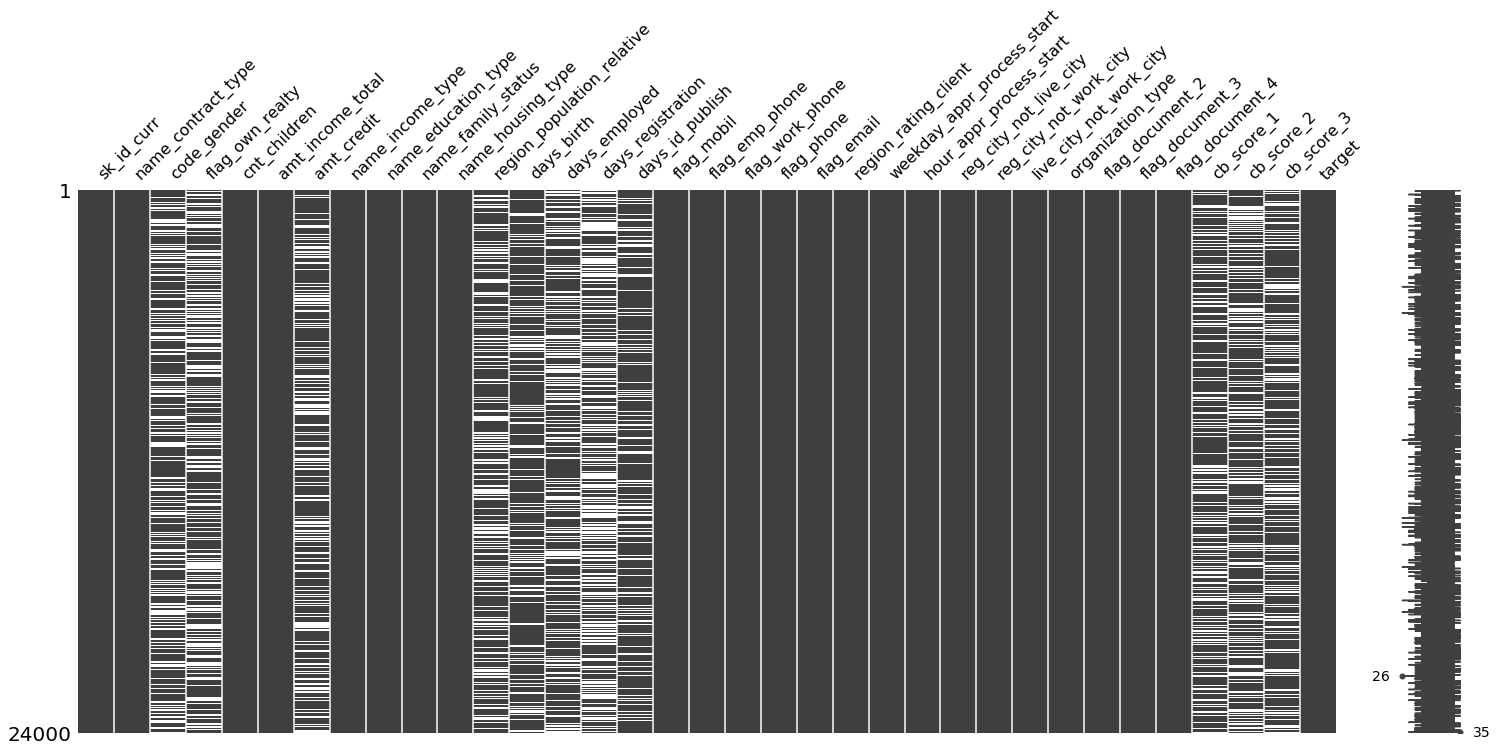

In [12]:
msno.matrix(df_eda) # 변수간 결측 분포

➡ 흰색 선으로 나타난 부분이 결측치 부분임 (총 11개 변수에 흰색 선이 나타남) <br>
➡ 특별히 결측변수간 연관관계는 보이지 않고 랜덤하게 결측값이 발생하는 것으로 보임 <br>
#오른쪽에 있는 것은 스파크라인(spark line)이라고 부르고, 각 행의 데이터 완성도를 표현함


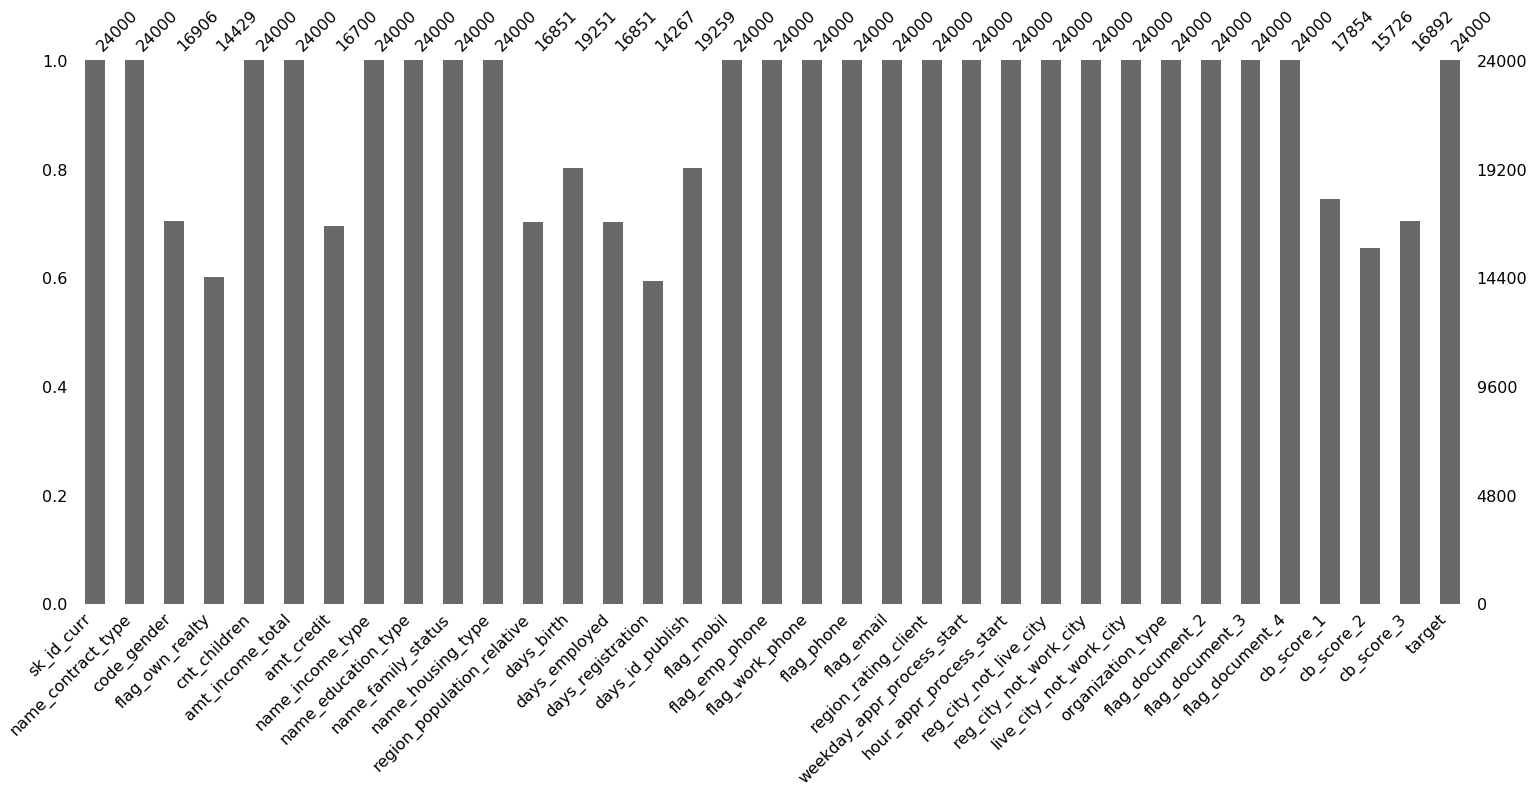

In [13]:
msno.bar(df_eda)    # 변수 별 결측 비율

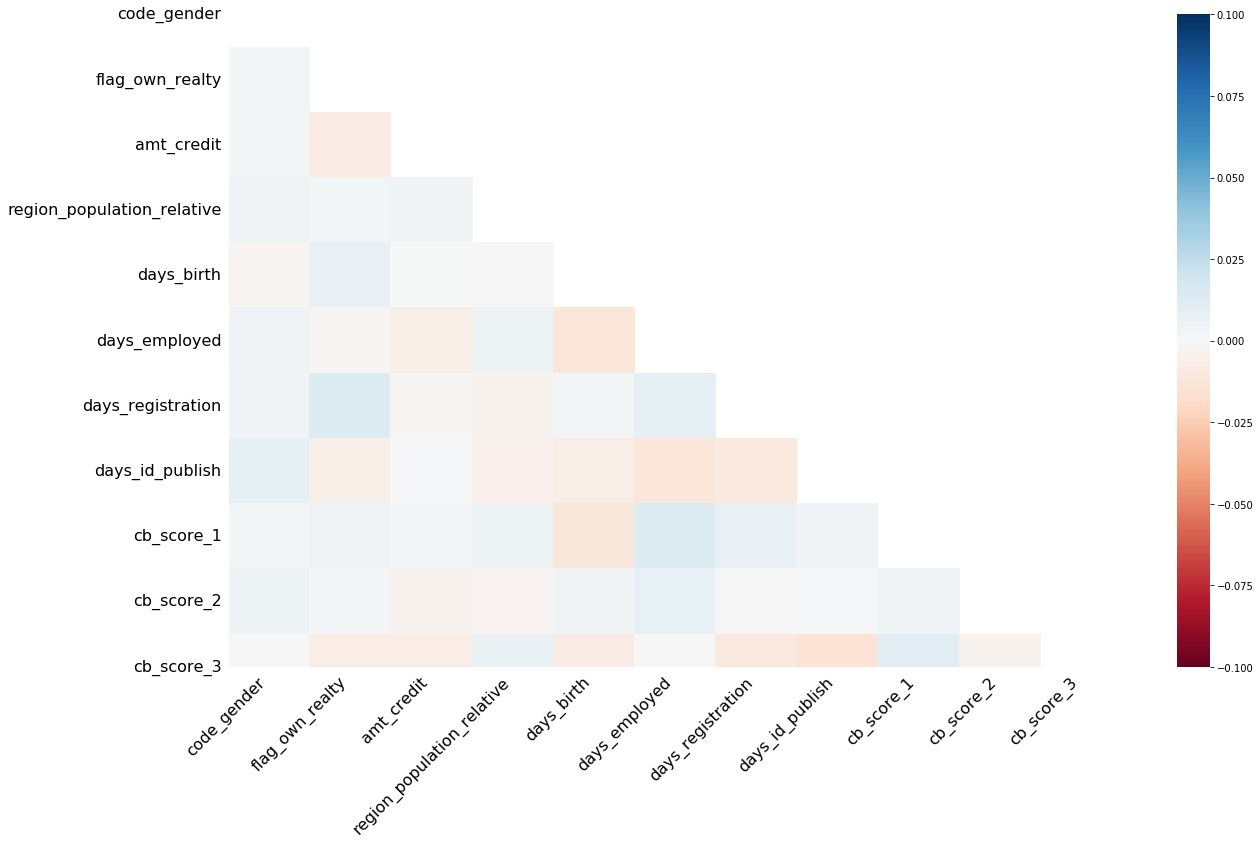

In [14]:
msno.heatmap(df_eda,vmin=-0.1, vmax=0.1)    # 변수 별 관계

➡  위 heatmap은 각 컬럼의 결측치끼리의 상관 관계를 측정함 (즉, 한 변수의 유무 여부가 다른 변수의 유무에 얼마나 영향을 미치는지 확인)<br>
➡ 각 컬럼들의 결측 유무가 다른 변수에 영향이 있어보이지 않음. 무작위 결측값으로 예상됨

<b>☑️ 결측값이 존재하는 컬럼</b>
 1. CODE_GENDER (성별) : 7,094 / 범주형
 2. FLAG_OWN_REALTY (자가부동산 보유여부) : 9,571 / 범주형
 3. AMT_CREDIT (신용대출금액-USD) : 7,300 / 연속형
 4. REGION_POPULATION_RELATIVE (거주 지역의 표준화된 인구) : 7,149 / 연속형
 5. DAYS_BIRTH (대출신청 시점에서의 일단위 나이) : 4,749 / 연속형
 6. DAYS_EMPLOYED (대출신청 시점에서의 고객의 근무일수) : 7,149 / 연속형
 7. DAYS_REGISTRATION (대출신청 이전에 고객이 등록정보를 변경한 시점 사이의 일수) : 9,733 / 연속형
 8. DAYS_ID_PUBLISH (대출신청 이전에 고객이 신분증을 변경한 시점 사이의 일수) : 4,741 / 연속형
 9. CB_SCORE_1 (신용점수1) : 6,146 / 연속형
 10. CB_SCORE_2 (신용점수2) : 8,274 / 연속형
 11. CB_SCORE_3 (신용점수3) : 7,108 / 연속형
 
 ➡  35개 컬럼 중 11개 컬럼에 결측값 존재함.<br>
 ➡  범주형 변수 2개, 연속형 변수 9개에 결측값 존재함.<br>
 ➡  생각보다 결측치가 많이 존재해서 이번 분석은 ""결측치를 어떻게 채워서 모델에 반영할지""가 중요한 과제라고 생각됨.

#### 4) 클래스 불균형 확인

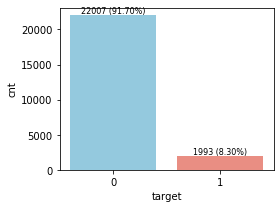

In [15]:
# '연체여부' 클래스 분포 확인
class_counts = df_eda['target'].value_counts()

# 전체 건수 계산
total_count = len(df_eda)

# Bar chart 그리기
plt.figure(figsize=(4, 3))
sns.countplot(data=df_eda, x='target', palette=['skyblue', 'salmon'])

# 클래스별 건수와 비중 표시
for i, count in enumerate(class_counts):
    percent = count / total_count * 100  # 클래스별 비중 계산
    plt.text(i, count, f'{count} ({percent:.2f}%)', ha='center', va='bottom', fontsize=8, color='black')

plt.xlabel('target')
plt.ylabel('cnt')

plt.tight_layout()
plt.show()

➡ target이 1인 사람이 8.3%로, 클래스의 불균형 확인 <br>
➡ 추후 모델링 진행 시, 클래스의 불균형을 고려하고, 성능에 영향을 줄이기 위해 해결해야 할 필요가 있음.

 ------------------------------------------------------------------------------

### 1-2. 컬럼 type별 분포 확인 및 데이터 1차 처리

: 컬럼별 상세 EDA 진행 전에, 전체적인 컬럼 확인 및 효과적인 EDA를 위한 데이터 1차 처리 진행

In [16]:
#카테고리 컬럼, 숫자형 컬럼 분리
cat_col = df_eda.select_dtypes(['object']).columns
num_col = df_eda.drop(columns = cat_col).columns

In [17]:
cat_col

Index(['name_contract_type', 'code_gender', 'flag_own_realty', 'cnt_children',
       'name_income_type', 'name_education_type', 'name_family_status',
       'name_housing_type', 'flag_mobil', 'flag_emp_phone', 'flag_work_phone',
       'flag_phone', 'flag_email', 'region_rating_client',
       'weekday_appr_process_start', 'hour_appr_process_start',
       'reg_city_not_live_city', 'reg_city_not_work_city',
       'live_city_not_work_city', 'organization_type', 'flag_document_2',
       'flag_document_3', 'flag_document_4'],
      dtype='object')

In [18]:
num_col

Index(['sk_id_curr', 'amt_income_total', 'amt_credit',
       'region_population_relative', 'days_birth', 'days_employed',
       'days_registration', 'days_id_publish', 'cb_score_1', 'cb_score_2',
       'cb_score_3', 'target'],
      dtype='object')

#### 1) 숫자형 컬럼 확인

In [19]:
df_eda[num_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sk_id_curr                  24000 non-null  int64  
 1   amt_income_total            24000 non-null  float64
 2   amt_credit                  16700 non-null  float64
 3   region_population_relative  16851 non-null  float64
 4   days_birth                  19251 non-null  float64
 5   days_employed               16851 non-null  float64
 6   days_registration           14267 non-null  float64
 7   days_id_publish             19259 non-null  float64
 8   cb_score_1                  17854 non-null  float64
 9   cb_score_2                  15726 non-null  float64
 10  cb_score_3                  16892 non-null  float64
 11  target                      24000 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 2.2 MB


In [20]:
df_eda[num_col].describe()

,sk_id_curr,amt_income_total,amt_credit,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,cb_score_1,cb_score_2,cb_score_3,target
count,24000.000000,2.400000e+04,1.670000e+04,16851.000000,19251.000000,16851.000000,14267.000000,19259.000000,17854.000000,15726.000000,16892.000000,24000.000000
mean,277994.337708,1.725182e+05,5.954254e+05,0.020989,-16026.527453,63041.865112,-5016.930118,-2990.491926,49.942357,58.061950,60.368432,0.083042
std,102778.811383,7.604604e+05,3.988125e+05,0.014061,4365.267387,140634.051334,3541.618561,1513.089981,13.095990,10.752802,8.682502,0.275951
min,100002.000000,2.700000e+04,4.500000e+04,0.000290,-25197.000000,-16852.000000,-24672.000000,-6263.000000,0.000000,0.000000,28.967147,0.000000
25%,188705.250000,1.125000e+05,2.700000e+05,0.010006,-19647.000000,-2772.000000,-7537.000000,-4308.000000,41.026337,50.801249,54.410659,0.000000
50%,277908.500000,1.440000e+05,5.108535e+05,0.018850,-15731.000000,-1206.000000,-4521.000000,-3251.000000,49.894802,57.935604,59.971539,0.000000
75%,366537.250000,2.025000e+05,8.086500e+05,0.028663,-12376.500000,-299.000000,-2050.500000,-1717.500000,58.919900,65.184718,66.097419,0.000000
max,456228.000000,1.170000e+08,4.050000e+06,0.072508,-7688.000000,365243.000000,0.000000,0.000000,99.870790,98.987986,100.000000,1.000000


##### - 숫자형 컬럼별 분포 확인

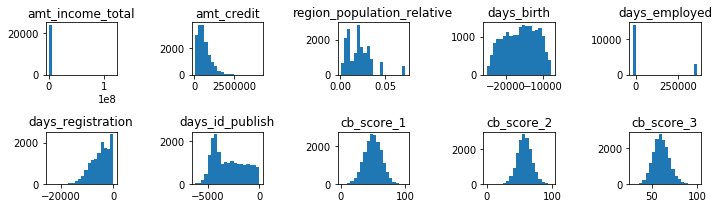

In [21]:
#sk_id_curr, target 제외한 숫자형 컬럼의 분포 확인
data = df_eda[num_col].iloc[:,1:-1]

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 3))

for i in range(2):
    for j in range(5):
        ax = axes[i, j]
        variable_index = i * 5 + j
        if variable_index < len(data.columns):
            variable_name = data.columns[variable_index]
            ax.hist(data[variable_name], bins=20) 
            ax.set_title(variable_name)

plt.tight_layout()

plt.show()

<b>☑️ 숫자형 데이터 처리 컬럼 (1차 처리)</b> <br>
1. amt_income_total (소득금액) : outlier 처리 필요 <br>
2. days 관련 4개 컬럼 : 일자 기준을 연 기준으로 변경 필요 <br>
   days_employed(고객 근무일수) : 양수값 처리 필요 (*양수값 : 고용되지 않은 상태 의미) <br> <br>
      ➡  outlier 처리, 연도 변환 등 1차 데이터 처리 필요 <br>
      ➡  숫자형 변수의 결측값은 추후 다른 변수와의 상관성을 본 후 처리 예정

#### 2) 숫자형 컬럼 1차 처리

##### - amt_income_total (소득금액)

outlier의 영향도를 줄이기 위해 소득금액의 이상값 처리 (박스 외부의 1.5배 IQR 이상 떨어진 데이터를 1.5배 IQR로 대체) <br>
 :  'amt_income_total_outlier' 변수 생성

In [22]:
#소득금액 이상값을 boxplot maximum 값으로 변경하기
# 'amt_income_total_outlier' 컬럼 생성 (조건에 따라 직접 설정)
# 박스플랏의 maximum 값보다 큰 값들은 모두 박스플랏의 maximum값으로 변경
numeric_outlier(df_eda,'amt_income_total')

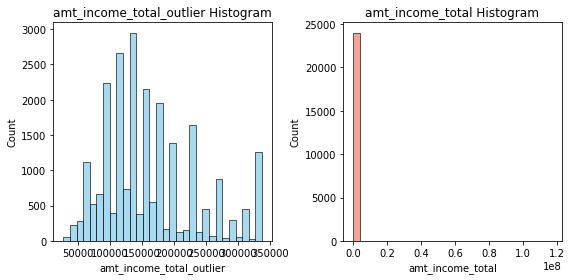

In [23]:
# 서브플롯 생성 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 1행 2열의 서브플롯 생성

# 첫 번째 서브플롯에 히스토그램 그리기
sns.histplot(df_eda['amt_income_total_outlier'], ax=axes[0], color='skyblue', bins = 30)
axes[0].set_title('amt_income_total_outlier Histogram')

# 두 번째 서브플롯에 히스토그램 그리기
sns.histplot(df_eda['amt_income_total'], ax=axes[1], color='salmon', bins = 30)
axes[1].set_title('amt_income_total Histogram')

plt.tight_layout()  # 서브플롯 간 간격 조정
plt.show()

이상값 처리 완료 (이상값 처리 후 / 전 그래프 비교)

##### - days 관련 컬럼 (4개)

 : 4개 컬럼 모두 음수값을 양수값으로 변경하고, 파악하기 쉽도록 일수가 아닌 "연수"로 확인할 수 있도록 변경 <br>
 : days_employed(고객 근무일수) 양수값을 일괄 -1 로 변경 <br>
 : 'year_birth','year_employed','year_registration','year_id_publish' 변수 생성

In [24]:
df_eda[['days_birth','days_employed','days_registration','days_id_publish']].describe()

,days_birth,days_employed,days_registration,days_id_publish
count,19251.000000,16851.000000,14267.000000,19259.000000
mean,-16026.527453,63041.865112,-5016.930118,-2990.491926
std,4365.267387,140634.051334,3541.618561,1513.089981
min,-25197.000000,-16852.000000,-24672.000000,-6263.000000
25%,-19647.000000,-2772.000000,-7537.000000,-4308.000000
50%,-15731.000000,-1206.000000,-4521.000000,-3251.000000
75%,-12376.500000,-299.000000,-2050.500000,-1717.500000
max,-7688.000000,365243.000000,0.000000,0.000000


In [25]:
# days 관련 변수에 대해 함수 적용
transform_and_divide_continuous_variable(df_eda, 'days_birth')
transform_and_divide_continuous_variable(df_eda, 'days_employed')
transform_and_divide_continuous_variable(df_eda, 'days_registration')
transform_and_divide_continuous_variable(df_eda, 'days_id_publish')

#컬럼명 변경
new_column_names = {
    'days_birth_y': 'year_birth',
    'days_employed_y': 'year_employed',
    'days_registration_y': 'year_registration',
    'days_id_publish_y': 'year_id_publish'
}
df_eda.rename(columns=new_column_names, inplace=True)

# 결과 확인
df_eda[['year_birth','year_employed','year_registration','year_id_publish']].describe()

,year_birth,year_employed,year_registration,year_id_publish
count,19251.000000,16851.000000,14267.000000,19259.000000
mean,43.410368,-173.184559,13.251770,7.703515
std,11.957483,385.237048,9.695409,4.142324
min,21.000000,-1001.000000,0.000000,0.000000
25%,33.000000,0.000000,5.000000,4.000000
50%,43.000000,3.000000,12.000000,8.000000
75%,53.000000,7.000000,20.000000,11.000000
max,69.000000,46.000000,67.000000,17.000000


In [26]:
#음수값이 존재하는 year_employed(근무연수) 컬럼에 대해 음수값을 -1로 일괄 변경하는 후처리 진행
#근무일수가 양수인 고객은 직장이 없는 고객으로 -1 로 지정해놓음 (직장 다닌지 1년 안 된 고객을 구분하기 위함)
day_outlier(df_eda, day=True)
day_outlier(df_eda, day=False)

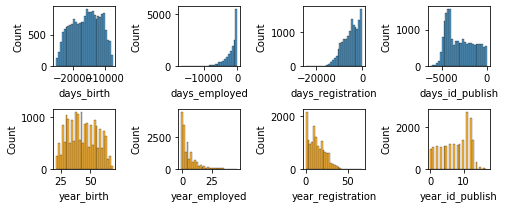

In [27]:
# 변경한 days 컬럼과 원래 days 컬럼의 분포 비교
fig, axes = plt.subplots(2, 4, figsize=(7, 3)) 

sns.histplot(df_eda['days_birth'], bins = 30, ax=axes[0,0])
sns.histplot(df_eda['days_employed'], bins = 30, ax=axes[0,1])
sns.histplot(df_eda['days_registration'], bins = 30, ax=axes[0,2])
sns.histplot(df_eda['days_id_publish'], bins = 30, ax=axes[0,3])
sns.histplot(df_eda['year_birth'], bins = 30, ax=axes[1,0], color='orange')
sns.histplot(df_eda['year_employed'], bins = 30, ax=axes[1,1], color='orange')
sns.histplot(df_eda['year_registration'], bins = 30, ax=axes[1,2], color='orange')
sns.histplot(df_eda['year_id_publish'], bins = 30, ax=axes[1,3], color='orange')

# 그래프 표시
plt.tight_layout()
plt.show()

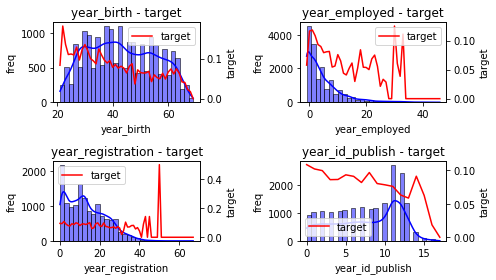

In [28]:
# 변경한 days 컬럼과 target 과의 관계 그래프 작성
fig, axes = plt.subplots(2, 2, figsize=(7, 4))

subplot_titles = ['year_birth', 'year_employed', 'year_registration', 'year_id_publish']

for i, col in enumerate(subplot_titles):
    sns.histplot(data=df_eda, x=col, bins=30, kde=True, color='blue', label='age', ax=axes[i // 2, i % 2])

    axes[i // 2, i % 2].set_xlabel(col)
    axes[i // 2, i % 2].set_ylabel('freq')
    axes[i // 2, i % 2].set_title(f'{col} - target')

    age_target_mean = df_eda.groupby(col)['target'].mean().reset_index()
    ax2 = axes[i // 2, i % 2].twinx()  # 오른쪽 축 생성
    sns.lineplot(data=age_target_mean, x=col, y='target', color='red', label='target', ax=ax2)

    ax2.set_ylabel('target')

plt.tight_layout()

plt.show()

➡  숫자형 데이터(amt_income_total, days 컬럼 4개) 처리 완료 <br>
➡  year_registration을 제외하고는 년 수가 길수록 연체확률이 줄어드는 분포를 보임 

##### - 숫자컬럼의 결측치 대체를 위해 컬럼 간 상관관계 확인

In [29]:
# num_col에 year 컬럼추가
num_col = df_eda.drop(columns = cat_col).columns

print(num_col)

Index(['sk_id_curr', 'amt_income_total', 'amt_credit',
       'region_population_relative', 'days_birth', 'days_employed',
       'days_registration', 'days_id_publish', 'cb_score_1', 'cb_score_2',
       'cb_score_3', 'target', 'amt_income_total_outlier', 'year_birth',
       'year_employed', 'year_registration', 'year_id_publish'],
      dtype='object')


In [30]:
# 숫자형 변수만 추출 -- income_total과 days는 각각 outlier와 year로 대체
numeric_columns = df_eda[['amt_income_total_outlier', 'amt_credit',
       'region_population_relative', 'cb_score_1', 'cb_score_2',
       'cb_score_3', 'year_birth', 'year_employed', 'year_registration', 'year_id_publish']]

In [31]:
numeric_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   amt_income_total_outlier    24000 non-null  float64
 1   amt_credit                  16700 non-null  float64
 2   region_population_relative  16851 non-null  float64
 3   cb_score_1                  17854 non-null  float64
 4   cb_score_2                  15726 non-null  float64
 5   cb_score_3                  16892 non-null  float64
 6   year_birth                  19251 non-null  float64
 7   year_employed               16851 non-null  float64
 8   year_registration           14267 non-null  float64
 9   year_id_publish             19259 non-null  float64
dtypes: float64(10)
memory usage: 1.8 MB


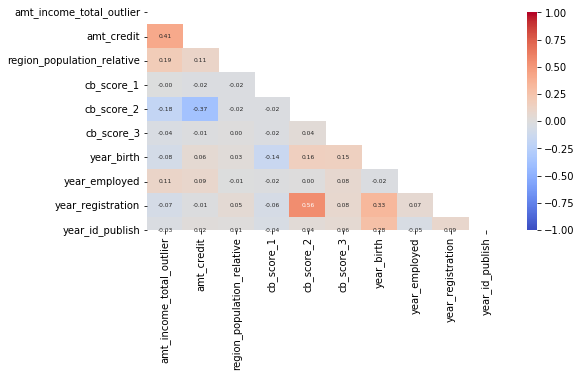

In [32]:
# 연속형 변수 간의 상관 계수 계산
correlation_matrix = numeric_columns.corr()

# correlation_matrix = pd.DataFrame(correlation_matrix)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(8, 4))
annot_kws = {"size": 6}
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", mask=mask, vmin=-1, vmax=1,annot_kws = annot_kws)

plt.show()

위 상관계수를 바탕으로 연속형 변수끼리의 관계를 참고하여 결측값 대체 시 활용할 예정

#### 3) 카테고리 컬럼 확인

##### - 범주형 변수의 결측값, 고유값 확인

In [33]:
# 범주형 변수의 컬럼명 추출
categorical_columns = df_eda.select_dtypes(include=['object']).columns

# 결과를 저장할 데이터프레임 초기화
summary_df = pd.DataFrame(columns=['Variable', 'Missing Values', 'Missing Percentage', 'Unique Values', 'Unique Value Counts'])

# 각 범주형 변수에 대한 정보를 계산하고 데이터프레임에 추가
for col in categorical_columns:
    missing_values = df_eda[col].isnull().sum()
    total_values = df_eda[col].count() + missing_values
    missing_percentage = (missing_values / total_values) * 100
    unique_values = df_eda[col].nunique()
    unique_value_counts = df_eda[col].value_counts().to_dict()
    
    summary_df = pd.concat([summary_df, pd.DataFrame({
        'Variable': [col],
        'Missing Values': [missing_values],
        'Missing Percentage': [missing_percentage],
        'Unique Values': [unique_values],
        'Unique Value Counts': [unique_value_counts]
    })])

# 결과 데이터프레임 출력
summary_df.reset_index(drop=True)

,Variable,Missing Values,Missing Percentage,Unique Values,Unique Value Counts
0,name_contract_type,0,0.000000,2,"{'Cash loans': 21733, 'Revolving loans': 2267}"
1,code_gender,7094,29.558333,3,"{'F': 11211, 'M': 5694, 'XNA': 1}"
2,flag_own_realty,9571,39.879167,2,"{'Y': 9939, 'N': 4490}"
3,cnt_children,0,0.000000,7,"{0: 16859, 1: 4703, 2: 2046, 3: 341, 4: 41, 5:..."
4,name_income_type,0,0.000000,7,"{'Working': 12460, 'Commercial associate': 552..."
5,name_education_type,0,0.000000,5,"{'Secondary / secondary special': 17054, 'High..."
6,name_family_status,0,0.000000,6,"{'Married': 15275, 'Single / not married': 355..."
7,name_housing_type,0,0.000000,6,"{'House / apartment': 21213, 'With parents': 1..."
8,flag_mobil,0,0.000000,1,{1: 24000}
9,flag_emp_phone,0,0.000000,2,"{1: 19706, 0: 4294}"


<b>☑️ 범주형 데이터 처리 컬럼 (1차 처리)</b> <br>
1. code_gender (성별) : 데이터 분포 확인을 위해 결측값 처리, 'XNA' 이상값 처리 필요
2. flag_own_realty (자가부동산 보유여부) : 결측값 처리 필요 <br>
3. flag_mobil (휴대폰 번호 등록 여부) : 전체 고객이 다 등록함 - 의미없는 컬럼으로 보임

#### 4) 카테고리 컬럼 1차 처리

##### - code_gender (성별)

In [34]:
# 1) code_gender
# 'XNA' 값, Null을 'NULL'로 대체
cat_null(df_eda, 'code_gender')

##### - flag_own_realty (자가부동산 보유 여부)

In [35]:
# 2) flag_own_realty
# NULL 값을 'NULL'로 대체
cat_null(df_eda, 'flag_own_realty')

##### - 범주형 변수의 분포 확인 (파이차트)

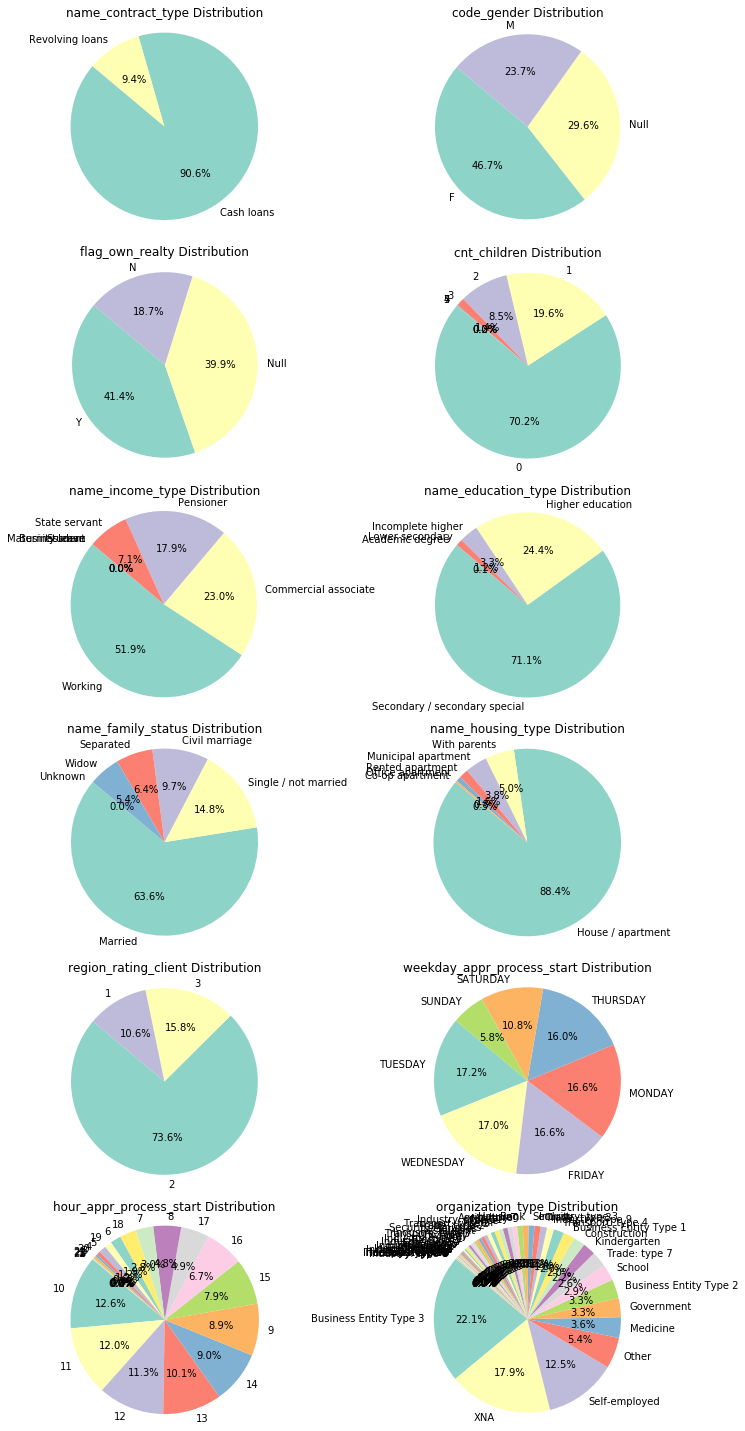

In [36]:
# 범주형 컬럼 리스트 (12개의 컬럼)
categorical_columns = ['name_contract_type', 'code_gender', 'flag_own_realty', 'cnt_children', 'name_income_type',
                       'name_education_type', 'name_family_status', 'name_housing_type', 'region_rating_client',
                       'weekday_appr_process_start', 'hour_appr_process_start', 'organization_type']

# Seaborn 컬러 팔레트 설정
palette = sns.color_palette("Set3", len(categorical_columns))

# 6개 행, 2개 열로 배치하여 파이차트 그리기
fig, axes = plt.subplots(6, 2, figsize=(10, 20))  # 6개 행, 2개 열의 서브플롯 생성

for i, column_name in enumerate(categorical_columns):
    row = i // 2  # 현재 컬럼을 어느 행에 배치할 것인지 계산
    col = i % 2   # 현재 컬럼을 어느 열에 배치할 것인지 계산
    
    counts = df_eda[column_name].value_counts()
    
    # 파이차트 그리기 (Seaborn 컬러 팔레트 적용)
    axes[row, col].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=palette)
    axes[row, col].set_title(f'{column_name} Distribution')  # 차트 제목 설정
    axes[row, col].axis('equal')  # 파이차트를 원형으로 표시

plt.tight_layout()  # 서브플롯 간 간격 조정
plt.show()

범주형 변수의 유효값 분포 확인

##### - 범주형 변수 간의 관계 파악 (카이제곱 검정)

In [37]:
chi_col = cat_col.append(pd.Index(['target']))
chi_col

Index(['name_contract_type', 'code_gender', 'flag_own_realty', 'cnt_children',
       'name_income_type', 'name_education_type', 'name_family_status',
       'name_housing_type', 'flag_mobil', 'flag_emp_phone', 'flag_work_phone',
       'flag_phone', 'flag_email', 'region_rating_client',
       'weekday_appr_process_start', 'hour_appr_process_start',
       'reg_city_not_live_city', 'reg_city_not_work_city',
       'live_city_not_work_city', 'organization_type', 'flag_document_2',
       'flag_document_3', 'flag_document_4', 'target'],
      dtype='object')

In [42]:
# 결과를 저장할 데이터프레임 생성
results = []

# target 범주형으로 변경
chi_df = df_eda[chi_col]
chi_df['target'] = chi_df['target'].astype('object')

# 카이제곱 검정 반복 수행
for col1 in chi_df.columns:
    for col2 in chi_df.columns:
        if col1 != col2:  # 같은 변수끼리 검정하지 않도록
            contingency_table = pd.crosstab(chi_df[col1], chi_df[col2])
            chi2, p, _, _ = chi2_contingency(contingency_table)
            results.append([col1, col2, chi2, p])

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results, columns=['Variable1', 'Variable2', 'Chi-squared', 'p-value'])

# p-value에 따라 정렬
results_df = results_df.sort_values(by='p-value', ascending = False)

# 결과 출력
results_df

,Variable1,Variable2,Chi-squared,p-value
30,code_gender,flag_mobil,0.000000,1.0
261,flag_phone,flag_mobil,0.000000,1.0
193,flag_mobil,flag_work_phone,0.000000,1.0
194,flag_mobil,flag_phone,0.000000,1.0
195,flag_mobil,flag_email,0.000000,1.0
...,...,...,...,...
400,reg_city_not_work_city,flag_emp_phone,1578.581989,0.0
223,flag_emp_phone,reg_city_not_work_city,1578.581989,0.0
457,organization_type,flag_document_3,1822.931930,0.0
225,flag_emp_phone,organization_type,24000.000000,0.0


In [43]:
results_df['p-value'] = results_df['p-value'].astype(float)
filtered_results = results_df.loc[(results_df['p-value'] > 0.00009) & (results_df['p-value'] <= 0.01)].sort_values(by='p-value', ascending=True)
filtered_results['p-value'] = filtered_results['p-value'].apply(lambda x: "{:.5f}".format(x))

In [44]:
filtered_results['p-value'].min()

'0.00011'

In [45]:
filtered_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 396 to 371
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Variable1    58 non-null     object 
 1   Variable2    58 non-null     object 
 2   Chi-squared  58 non-null     float64
 3   p-value      58 non-null     object 
dtypes: float64(1), object(3)
memory usage: 2.3+ KB


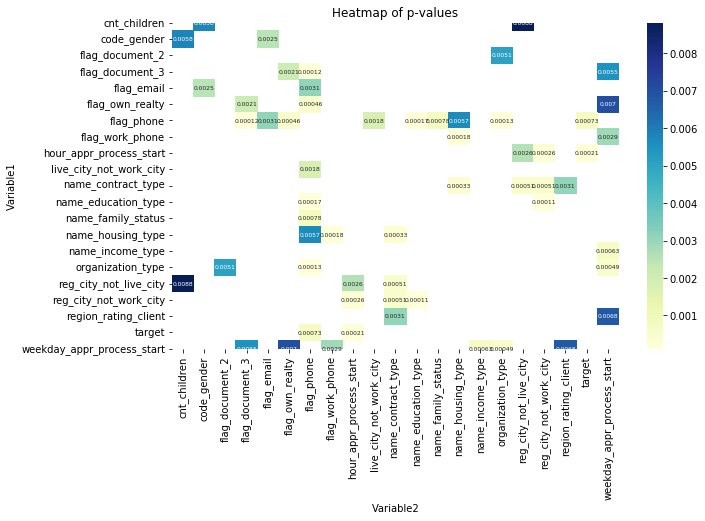

In [46]:
filtered_results['p-value'] = filtered_results['p-value'].astype(float)

pivot_df = filtered_results.pivot(index='Variable1', columns='Variable2', values='p-value')

plt.figure(figsize=(10, 6))

annot_kws = {"size": 6}

sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", annot_kws=annot_kws)
plt.title('Heatmap of p-values')
plt.show()

In [47]:
filtered_results.groupby('Variable1')['p-value'].mean().sort_values()

Variable1
name_education_type           0.000140
reg_city_not_work_city        0.000293
target                        0.000470
name_income_type              0.000630
name_family_status            0.000780
hour_appr_process_start       0.001017
name_contract_type            0.001110
flag_phone                    0.001444
flag_work_phone               0.001545
live_city_not_work_city       0.001840
organization_type             0.001903
name_housing_type             0.002057
flag_document_3               0.002580
flag_email                    0.002805
flag_own_realty               0.003210
weekday_appr_process_start    0.003890
reg_city_not_live_city        0.003970
code_gender                   0.004155
region_rating_client          0.004925
flag_document_2               0.005090
cnt_children                  0.007315
Name: p-value, dtype: float64

In [48]:
#target과 연관성이 있다고 나온 컬럼 확인
filtered_results.loc[filtered_results['Variable1'] == 'target']

,Variable1,Variable2,Chi-squared,p-value
544,target,hour_appr_process_start,54.816932,0.00021
540,target,flag_phone,11.418564,0.00073


크게 유의미한 수치는 아니지만, 삭제하지는 않고 분석에 활용해볼 예정.

 ------------------------------------------------------------------------------

### 1-3. 데이터 상세 탐색

(1-1. 전체적인 데이터 탐색)에서 말했던 *고객의 3가지 특성을 나눠서 확인해보면서 데이터 상세 탐색을 진행하고자 함

<b>☑️ 고객의 3가지 특성</b><br>

1️⃣ 인구통계학적/재무적 특성<br>
- 성별 - code_gender
- 자가부동산보유여부 -  flag_own_realty
- 자녀수 -  cnt_children
- 소득금액(USD) -  amt_income_total
- 소득유형 -  name_income_type
- 학력 -  name_education_type
- 결혼 상태 -  name_family_status
- 주거 상태 -  name_housing_type
- 거주지역의 표준화된 인구 -  region_population_relative
- 나이(대출신청 시점에서의 고객의 일단위 나이) -  days_birth
- 근무일수(대출신청 시점에서의 고객의 일단위 근무일수) -  days_employed
- 거주지 등급 -  region_rating_client
- 근무회사 유형 - organization_type

2️⃣ 대출/연체 정보 <br>
- 대출 식별번호  - sk_id_curr
- 대출상품  - name_contract_type
- 신용대출 금액 -  amt_credit   
- 대출 신청 요일  - weekday_appr_process_start
- 대출 신청 시간대  - hour_appr_process_start
- 연체 정보 (* target 변수 *)

3️⃣ 대출 신청 관련 고객 등록정보/제공정보 <br>
- 대출신청 이전 고객정보 변경 일수 -  days_registration
- 대출신청 이전 신분증 변경 일수 -  days_id_publish
- 휴대폰번호 등록 여부 -  flag_mobil
- 고용주 연락처 등록 여부 -  flag_emp_phone
- 직장전화번호 등록 여부 - flag_work_phone
- 집 전화번호 등록 여부 -  flag_phone
- 이메일 주소 등록 여부  - flag_email
- 고객의 등록지 주소와 실거주지 일치 여부  - reg_city_not_live_city
- 고객의 등록지 주소와 직장주소 일치 여부  - reg_city_not_work_city
- 고객의 실거주지와 직장주소 일치 여부  - live_city_not_work_city
- 문서2 제공여부 - flag_document_2
- 문서3 제공여부 - flag_document_3
- 문서4 제공여부 - flag_document_4
- 신용점수 1 - cb_score_1
- 신용점수 2 - cb_score_2
- 신용점수 3 - cb_score_3


> 연속형 변수, 범주형 변수 분리

In [49]:
num_col = df_eda.select_dtypes('float').columns

#days 컬럼은 year로 대체해서 확인
num_col = [col for col in num_col if not col.startswith('days_')]

#income_total은 이상치 처리한 log 컬럼으로 확인
num_col.remove('amt_income_total')

In [50]:
cat_col = df_eda.select_dtypes('object').columns

> 시각화 함수

In [51]:
#범주형 변수의 분포와 유효값 별 연체와의 관계성을 보는 함수생성
def cat_col_plt(df, cat_col):
    # subplot 생성
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
    
    # 성별 분포 히스토그램
    sns.histplot(df[cat_col], ax=axes[0])
    axes[0].tick_params(axis='x', rotation=45)  # x축 레이블을 45도 회전

    # 성별에 따른 연체 여부 평균
    sns.barplot(x=cat_col, y='target', data=df, ax=axes[1])#, width = 0.6)
    axes[1].set_xlabel(cat_col)
    axes[1].set_ylabel('target_ratio')
    axes[1].tick_params(axis='x', rotation=45)  # x축 레이블을 45도 회전

    # 그래프 간 간격 조정
    plt.tight_layout()

    # 그래프 표시
    plt.show()

In [52]:
#연속형 변수와 연체와의 관계를 보는 시각화 함수
def num_col_plt(df, num_col):

    # subplot 생성
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # 특정 연속형 변수의 결측치 비율 계산
    missing_ratio = (df[num_col].isnull().sum() / len(df)) * 100

    # 결측치 비율을 파이 차트로 시각화
    axes[0].pie([missing_ratio, 100 - missing_ratio], labels=['Missing', 'Non-Missing'], colors=['orange', 'skyblue'], autopct='%1.1f%%')
    axes[0].set_title(f'Missing Value')

    # 연속형 변수의 히스토그램을 그림
    axes[1].hist(df[num_col], color='green')
    axes[1].set_xlabel(num_col)
    axes[1].set_ylabel('Frequency', color='green')
    axes[1].set_title(f'{num_col} - target')

    # 오른쪽 축 생성
    ax2 = axes[1].twinx()

    # 연속형 변수와 target 간의 라인 그래프 생성
    sns.lineplot(data=df, x=num_col, y='target', color='red', ax=ax2)
    ax2.set_ylabel('Target Ratio', color='red')

    plt.tight_layout()
    plt.show()


In [53]:
def cat_num_boxplot(df, cat_col, num_col):

    num_cols_count = len(num_col)
    
    num_rows = num_rows = int(max(round(num_cols_count / 5,0), 1))
    # num_rows = 2  # 원하는 행 개수
    num_cols = min(num_cols_count, 5)  # 원하는 열 개수
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 2.5, num_rows * 3))

    if num_rows > 1:
        for i in range(num_rows):
            for j in range(num_cols):
                if (i * num_cols + j) < num_cols_count:
                    col = num_col[i * num_cols + j]
                    df.boxplot(column=col, by=cat_col, ax=axes[i, j])
                    axes[i, j].set_title(col) 
                    axes[i, j].tick_params(axis='x', labelrotation=90)
    else :
        for i, col in enumerate(num_col):
            df.boxplot(column=col, by=cat_col, ax=axes)
            axes.set_title('')
            axes.tick_params(axis='x', labelrotation=90)
                    

    plt.subplots_adjust(wspace=0.5)
    plt.subplots_adjust(hspace=0.8)
    plt.show()

#### 1) 인구통계학적/재무적 특성

##### - code_gender (성별)

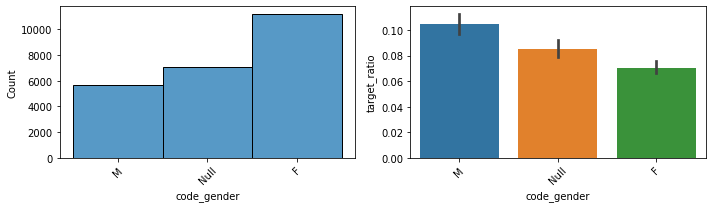

In [54]:
cat_col_plt(df_eda, 'code_gender')

➡ 여성의 수가 훨씬 많고, 여성의 target ratio가 상대적으로 낮은 것으로 보이나,<br>
➡ 결측의 비율이 높으며 target ratio의 차이가 크지 않기 때문에 결측치 처리에 대한 고민이 필요함 <br>
➡ 임의로 결측값을 채우거나 삭제하는 것보다는 결측값을 결측이라고 표시해서 정보를 남겨두는 것도 괜찮을 것 같음 

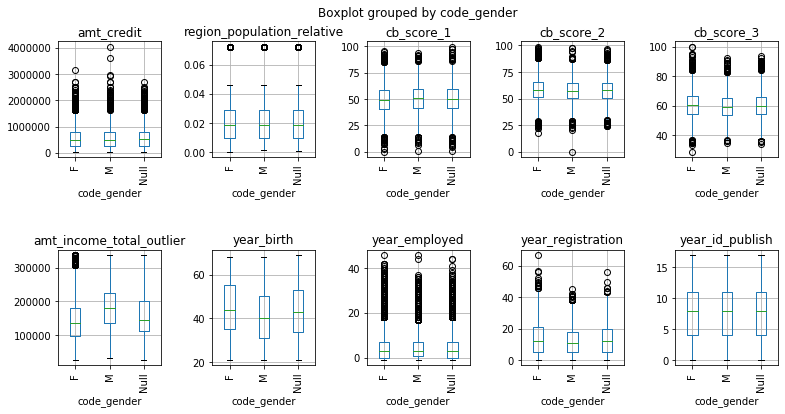

In [55]:
cat_num_boxplot(df_eda, 'code_gender', num_col)

➡ 남자가 여자보다 소득금액이 높고, 평균 연령은 어려보임 <br>
➡ 평균 소득금액이 더 높은 남자가 target ratio은 더 높은 것으로 보여짐

##### - flag_own_realty (자가부동산보유여부)

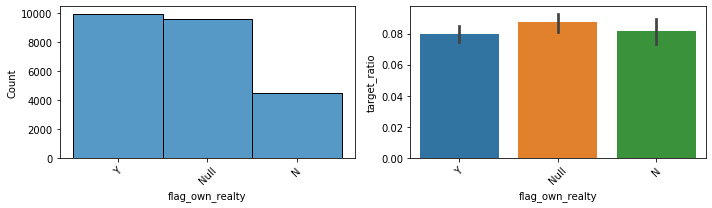

In [56]:
cat_col_plt(df_eda, 'flag_own_realty')

➡ 자가부동산 보유여부에 따른 연체여부 차이는 없음.<br>
➡ 결측의 비율이 높으며 target ratio의 차이가 크지 않기 때문에 결측치 처리에 대한 고민이 필요함<br>
➡ 성별과 마찬가지로 임의로 결측값을 채우거나 삭제하는 것보다는 결측값을 결측이라고 표시해서 정보를 남겨두는 것도 괜찮을 것 같음 

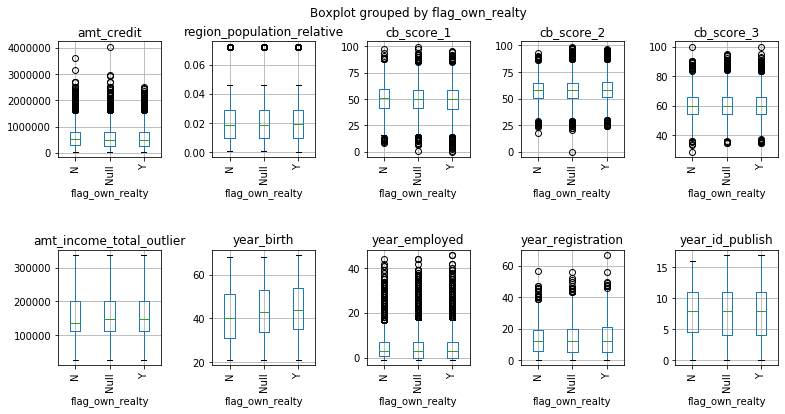

In [57]:
cat_num_boxplot(df_eda, 'flag_own_realty', num_col)

➡ 자가부동산보유여부에 따른 연속형 컬럼을 확인했을 때, 눈에 띄는 특징이 보이지는 않음 

##### - cnt_children (자녀수) ✔️

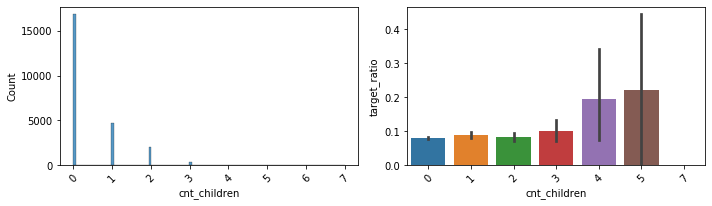

In [58]:
cat_col_plt(df_eda, 'cnt_children')

➡ 자녀 수가 많을 수록 연체율이 높아지는 것처럼 보이나, 모수가 작은 영향도 있을 것으로 예상됨<br>

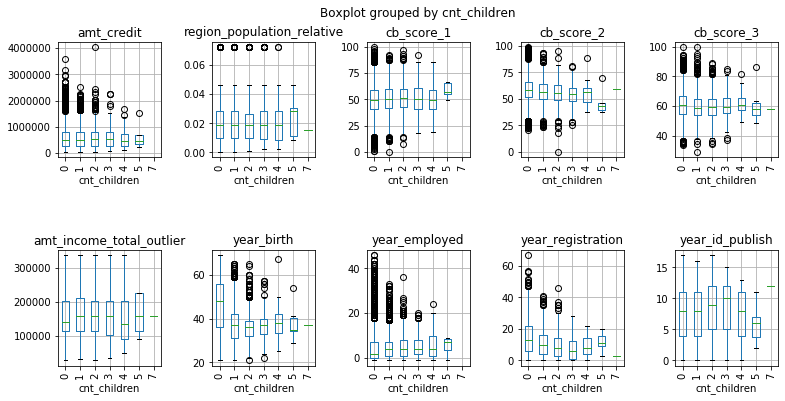

In [59]:
cat_num_boxplot(df_eda, 'cnt_children', num_col)

➡ 자녀 수가 0명인 고객의 평균 나이가 가장 많고, 넓게 퍼져있음 <br>
➡ 자녀 수가 5명인 고객의 cb_score 1, 2가 튀어보이지만, 모수가 작은 영향이 있어보임 <br>
- 자녀 유무에 따른 분포도 확인해 볼 필요가 있음<br>


##### ** child_yn (자녀유무)

In [60]:
# 자녀 유무에 따라 확인해보기
df_eda['child_yn'] = df_eda['cnt_children'].apply(lambda x: 'Y' if x > 0 else 'N')

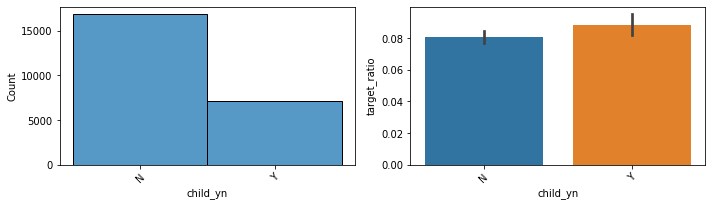

In [61]:
cat_col_plt(df_eda, 'child_yn')

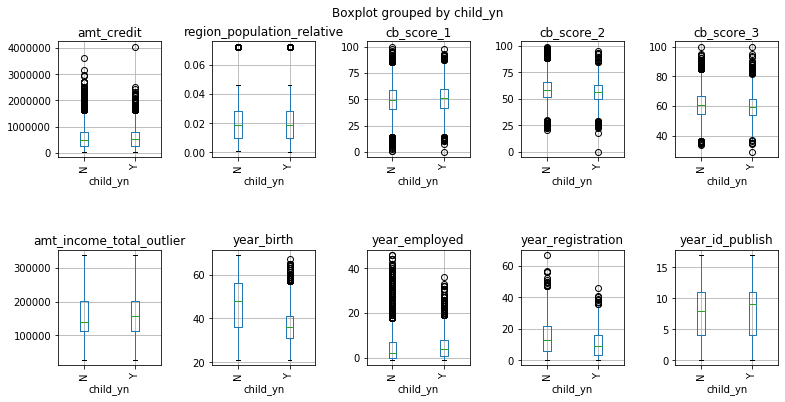

In [62]:
cat_num_boxplot(df_eda, 'child_yn', num_col)

➡ 자녀 유무로 구분해서 봤을 때, 모수 차이가 나긴 하지만 자녀가 있는 사람이 없는 사람보다 연체확률이 높고 특성 차이도 있어보임  (year_birth, year_registration) <br>

##### - name_income_type (소득유형) ✔️

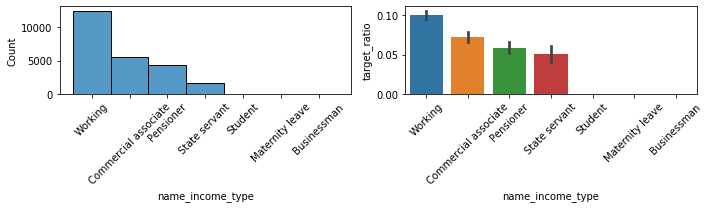

In [63]:
cat_col_plt(df_eda, 'name_income_type')

➡ commercial associate, pensioner의 경우 대상 수 대비 연체확률이 높은 것으로 보여짐<br>
➡ 유효값이 많기 때문에 그룹핑을 하는 것이 나을 것 같고,<br>
  - Working / commercial, associate, pensioner / 나머지 로 묶을 지, <br>
  - 연관된 다른 범주형 변수를 고려해볼지 생각해봐야함

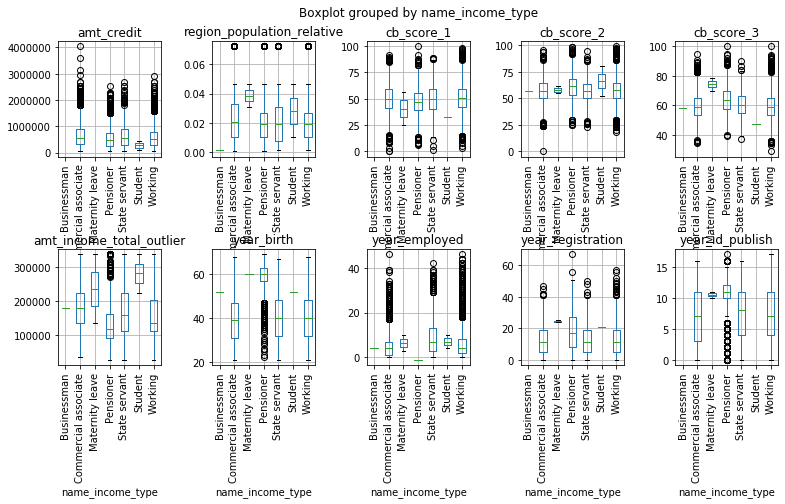

In [64]:
cat_num_boxplot(df_eda, 'name_income_type', num_col)

➡ 소득유형 컬럼 유효값별로 연속형 변수의 분포 차이가 존재함 - 의미가 있는 컬럼으로 생각됨<br>
➡ Working, Commercial associate, State servant가 연속형 변수에서 비슷한 분포를 보임  <br>
➡ Businessman, Maternity leave, Student는 모수가 많이 없어서 분포가 튀는 것으로 보여짐 <br>
➡ Pensioner(연금수령자)의 경우 연령이 다른 소득유형에 비해 높고, 
  year_id_publish에서 다른 소득유형과는 다른 분포를 보임 <br>
  - 소득유형을 그룹핑할 때 Pensioner을 따로 구분하는 것이 좋아보임

##### ** is_pensioner (연금수령자 여부)

In [65]:
df_eda['is_pensioner'] = df_eda['name_income_type'].apply(lambda x: 'Y' if x == 'Pensioner' else 'N')

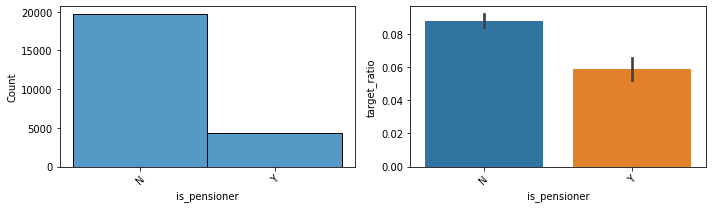

In [66]:
cat_col_plt(df_eda,'is_pensioner')

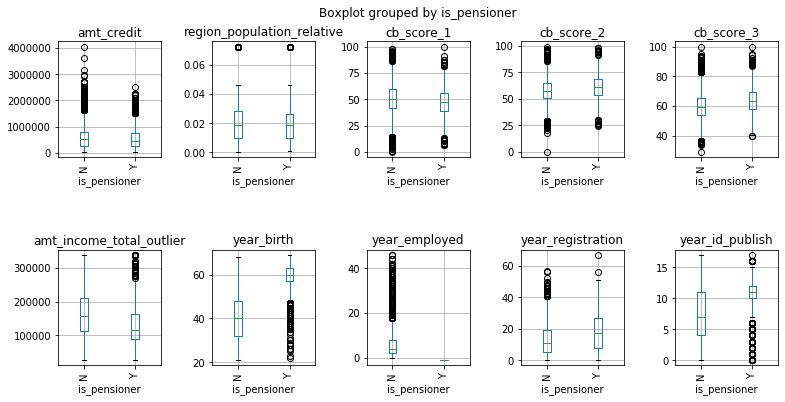

In [67]:
cat_num_boxplot(df_eda, 'is_pensioner', num_col)

➡ 연금수령자 여부에 따라 연속형 변수의 특성 차이가 존재하는 것으로 보임<br>
➡ 연금수령자가 소득금액이 더 낮고, 연령대가 높으며 신분증 등록 한지도 오래됨. (연령과 신분증 등록 기간과 연관이 있을 것 같음)<br>


##### - name_education_type (학력) ✔️

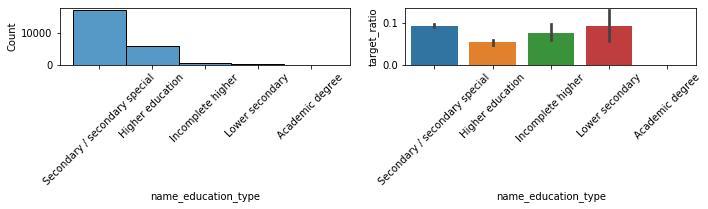

In [68]:
cat_col_plt(df_eda, 'name_education_type')

➡ 학력에 따른 연체 차이가 보이긴하나, 낮은 학력이 연체율이 높다라는 결론은 위험해보임<br>

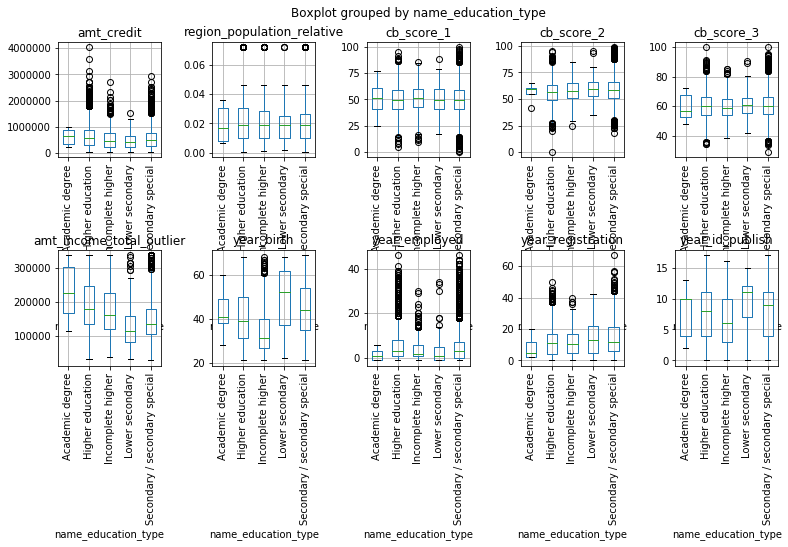

In [69]:
cat_num_boxplot(df_eda, 'name_education_type', num_col)

➡ 학력이 높을수록 amt_income_total(소득금액) 이 높음 <br>
➡ amt_credit(대출금액)도 학력순서대로는 아니지만, 고학력 저학력과 비교하면 차이가 나는 것으로 보임<br>
  **학력 순서 : Academic degree > Higher education > Incomplete higher > Secondary / secondary special > Lower secondary <br>
  - 학력 컬럼은 연체 및 고객 특성을 확인하는데 유의미한 컬럼으로 보여짐

##### - name_family_status (가족유형)

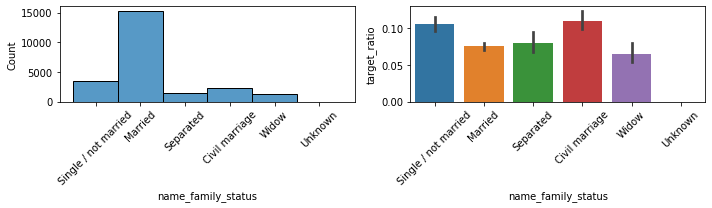

In [70]:
cat_col_plt(df_eda, 'name_family_status')

➡ 전체 고객의 60% 이상이 결혼함 <br>
➡ 가족유형별로 그룹핑 하고 싶은데 어떤 식으로 해야 할지 고민됨

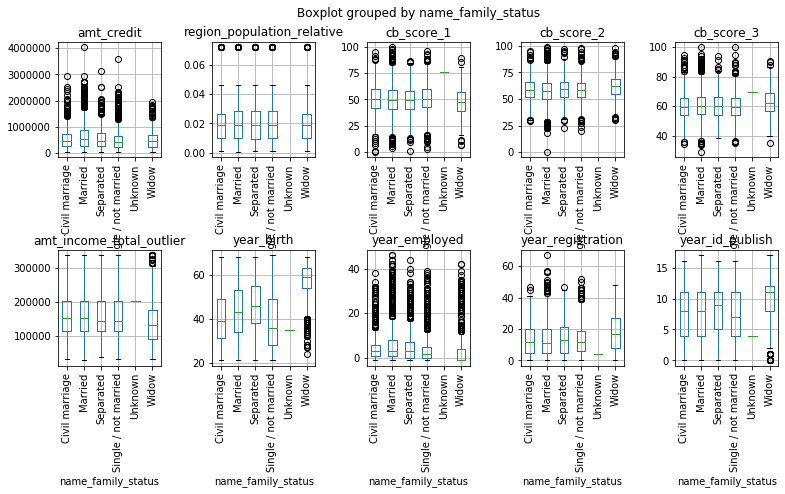

In [71]:
cat_num_boxplot(df_eda, 'name_family_status', num_col)

➡ Widow(과부)의 year_registration, year_id_publish의 평균이 다른 가족형태 대비 큼 <br>
➡ 특성 상관 없이 유효값만 보고 결혼 유지그룹(Married, Civil marriage), 헤어진 그룹(Separated, Widow), 그 외(Single, Unknown)로 구분 지어서 반영하는 것도 괜찮을 것 같음
  - 가족유형을 나눠서 모델에 반영 해봤으나, 성능에 큰 영향이 없어서 제외함

##### - name_housing_type (주거지유형) ✔️

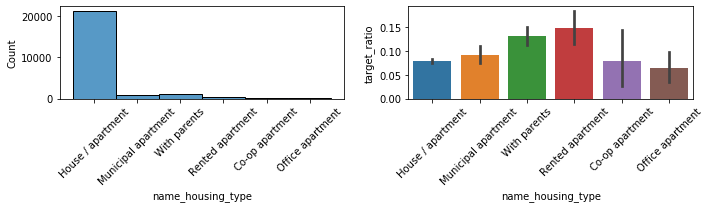

In [72]:
cat_col_plt(df_eda, 'name_housing_type')

➡ 약 60% 고객이 House/apartment에 거주하고 있음 <br>
➡ With_parents, Rented apt target ratio가 높음

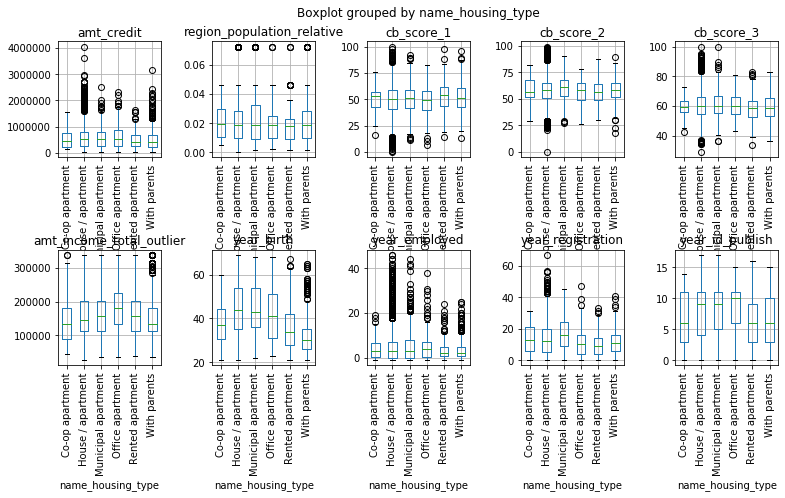

In [73]:
cat_num_boxplot(df_eda, 'name_housing_type', num_col)

➡ 연령대에 따라 주거지유형이 다르다 (With parents, Rented apartment의 평균 연령대가 가장 낮음) <br>
➡ With parents, Rented apartment의 target ratio는 상대적으로 컸던 것으로 보아 나이가 어릴수록 부도 가능성이 높을 것으로 예상됨 <br>
- target ratio가 높은 With_parents, Rented apt / 나머지를 grouping 해볼 수 있을 듯

##### ** housing_group (주거지유형 그룹 )

In [74]:
# 그룹 나눠서 보기
housing_group_mapping = {
    'Co-op apartment': 'A',
    'House / apartment': 'A',
    'Municipal apartment': 'A',
    'Office apartment': 'A',
    'Rented apartment': 'B',
    'With parents': 'B'
}

df_eda['housing_group'] = df_eda['name_housing_type'].map(housing_group_mapping)

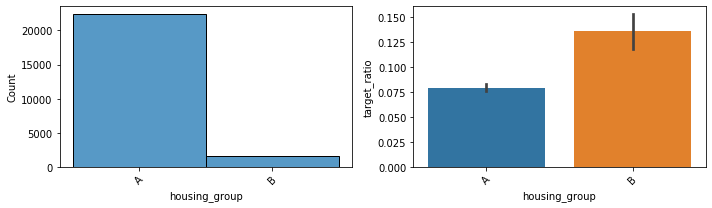

In [75]:
cat_col_plt(df_eda,'housing_group')

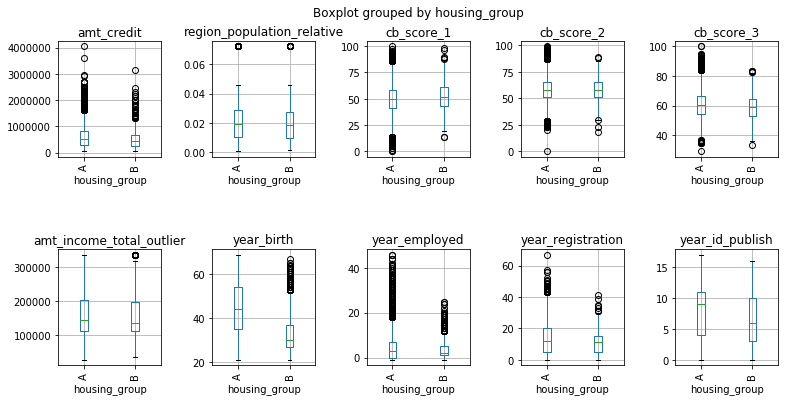

In [76]:
cat_num_boxplot(df_eda, 'housing_group', num_col)

##### - region_rating_client (주거지등급) ✔️

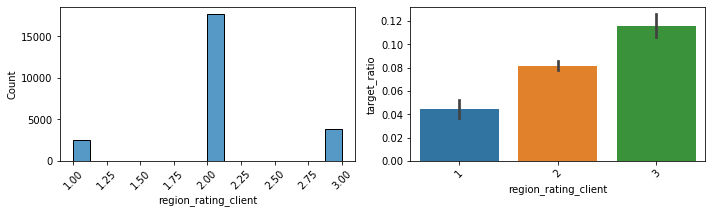

In [77]:
cat_col_plt(df_eda, 'region_rating_client')

➡ 모수가 다르지만 주거지 등급에 따라 연체율의 차이를 보이기는 함.<br>

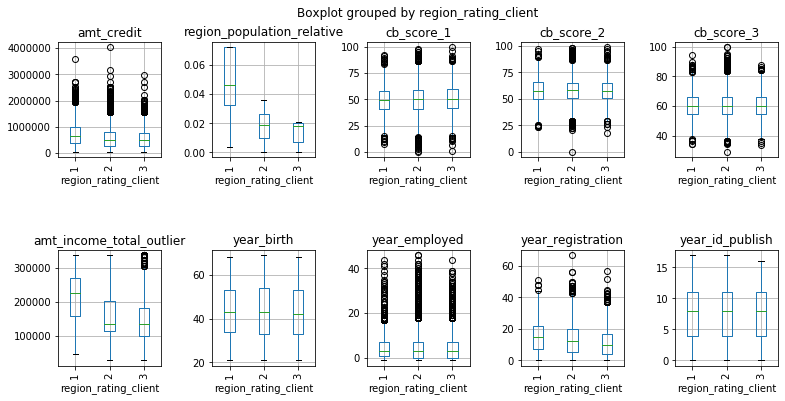

In [78]:
cat_num_boxplot(df_eda, 'region_rating_client', num_col)

➡ 주거지 등급이 높을수록 거주지역의 인구가 많음 (살기 좋은 곳에 사람이 몰리는 것 같음)<br>
➡ 주거지 등급이 높을수록 소득금액도 높은 것으로 보여짐 <br>
➡ 주거지 등급 컬럼은 연체 및 고객 특성을 확인하는데 유의미한 컬럼으로 보임

##### - organization_type (직장유형)

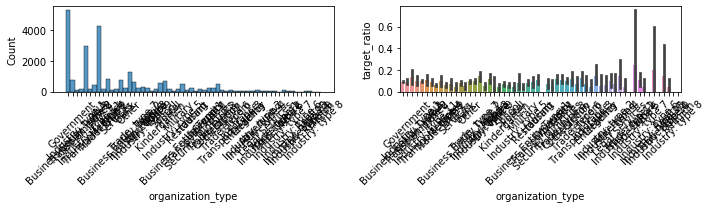

In [79]:
cat_col_plt(df_eda, 'organization_type')

➡ 유효값이 총 58개로 너무 많아서 파악하기 어려움.<br>
➡ 직장유형명을 보고 직접 임의로 grouping하기엔 오류가 많을 수 있음<br>
- 모델 반영 시 클러스터링 등 진행을 통해 유효값을 줄여야 할 필요가 있어보임 

##### - amt_income_total (소득금액)

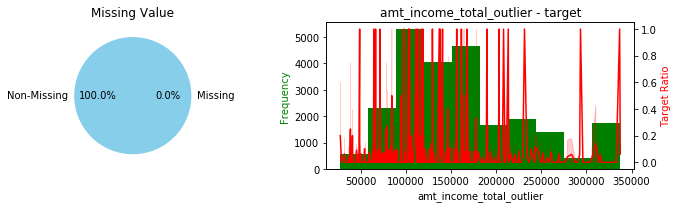

In [80]:
num_col_plt(df_eda, 'amt_income_total_outlier')

➡ 소득금액별 target의 평균은 적절치 않아 일정구간으로 bin을 설정하여 다시 확인

In [81]:
tmp = df_eda.copy()

In [82]:
bin_width = 5000
tmp['amt_income_total_outlier_bins'] = pd.cut(df_eda['amt_income_total_outlier'], 
                                             bins=np.arange(df_eda['amt_income_total_outlier'].min(), 
                                                            df_eda['amt_income_total_outlier'].max() + bin_width, 
                                                            bin_width),
                                             right=True)  # right=False로 설정하면 왼쪽 포함, 오른쪽 미포함 구간

# 중간값(평균) 계산하여 새로운 컬럼에 할당
tmp['amt_income_total_outlier_mean'] = tmp['amt_income_total_outlier_bins'].apply(lambda x: (x.left + x.right) / 2)

# 결과 확인
print(tmp[['amt_income_total_outlier_bins', 'amt_income_total_outlier_mean']].head(2))


  amt_income_total_outlier_bins amt_income_total_outlier_mean
0          (202000.0, 207000.0]                      204500.0
1            (67000.0, 72000.0]                       69500.0


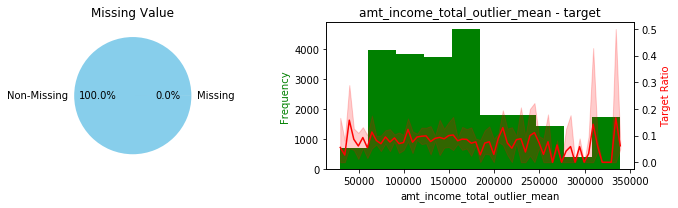

In [83]:
num_col_plt(tmp, 'amt_income_total_outlier_mean')

➡ 소득수준과 연체는 크게 상관이 없는 것으로 보여짐

##### - region_population_relative (거주 지역의 표준화된 인구)

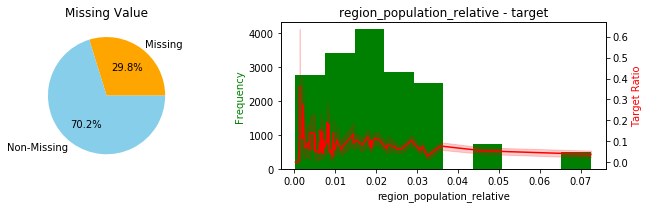

In [84]:
num_col_plt(df_eda, 'region_population_relative')

➡ 결측치 30%가 있음<br>
➡ 주거지등급과 연관이 있을 듯 함

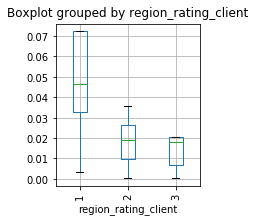

In [85]:
cat_num_boxplot(df_eda, 'region_rating_client', ['region_population_relative'])

➡ 거주지역의 표준화된 인구 수와 주거지등급은 연관성이 있어보임. <br>
➡ 거주지역의 표준화된 인구 수 컬럼의 결측치를 주거지등급별 평균 or 중간값으로 채우기에는 결측치 비율이 높아서 오히려 예측력이 낮아질 수도 있을 것 같음 <br>
➡ 3개로 나누어진 주거지등급보다 세밀하게 영향이 있을 것이라 판단되어 삭제하지는 않되, 결측치 처리는 다른 연속형변수와 연관지어서 생각해보는 것도 좋을 듯 함.

##### - days_birth, days_employed (나이, 근무기간) ✔️
    - days 컬럼은 year로 변경하여 위에서 확인함.

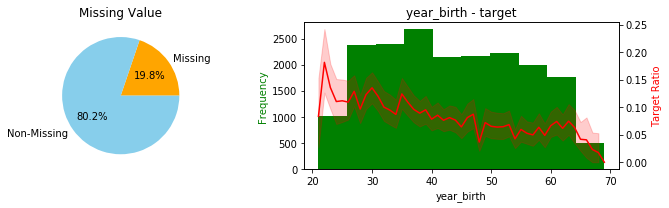

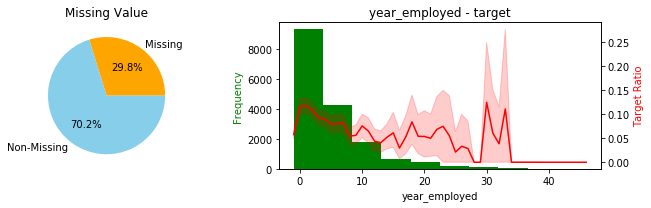

In [86]:
num_col_plt(df_eda, 'year_birth')
num_col_plt(df_eda, 'year_employed')

➡ 나이가 많을수록 target ratio가 감소함. 나이가 어릴수록 연체할 가능성이 높다고도 볼 수 있을듯<br>
➡ 미세하지만 근무기간이 길수록 target ratio가 감소하는 경향을 보임<br>
➡ 결측 비율이 높아 결측치 처리 방법이 필요함

---

#### 2) 대출/연체정보

##### - name_contract_type (상품)

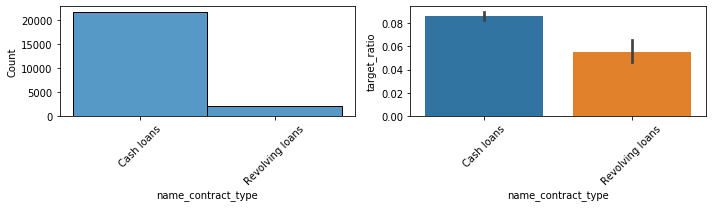

In [87]:
cat_col_plt(df_eda, 'name_contract_type')

➡ 90% 고객이 Cash loans를 받았고, Revolving loans보다 target ratio가 높음  <br>
➡ 다른 연속형 변수와는 관계가 없는지 확인 

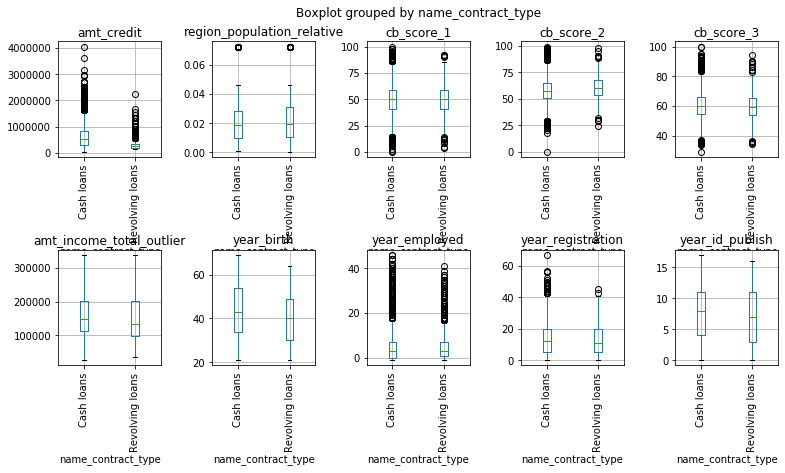

In [88]:
cat_num_boxplot(df_eda, 'name_contract_type', num_col)

➡ 상품 간 신용대출 금액과 나이에서는 확실히 차이를 보임 <br>
➡ Revolving loans는 마이너스 통장 대출로 대출금액이 신용대출 대비 낮을 수 밖에 없음. 

- Cash Loans (현금 대출):<br>
    통상 한도만큼 대출금이 지급되고, 금리에 따라 월 상환액이 설정되며, 대출 기간 분할상환되는 구조의 상품<br>
    차량 대출 등<br><br>
    
- Revolving Loans (회전 대출):<br>
    마이너스 통장의 개념. 차주가 한도 내에서 원하는 만큼 돈을 차용하고 상환하는 구조로, 월 상환액이 일정하지 않음 <br>
    신용카드 대출 등

##### - weekday_appr_process_start (대출신청요일)

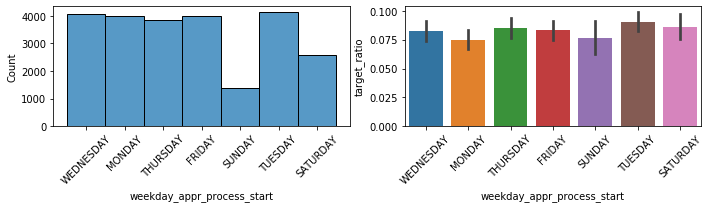

In [89]:
cat_col_plt(df_eda, 'weekday_appr_process_start')

➡ 요일별로 연체율의 차이는 크게 없어보이나, 건수에는 약간 차이가 있음<br>
➡ 건수 기반으로 주말/평일을 나눌 지, 연체율기반으로 월,일요일/나머지로 나눌 지 고민해보기
 - 요일을 나눠서 모델링에 반영 해봤으나, 성능에 큰 영향이 없어서 제외함


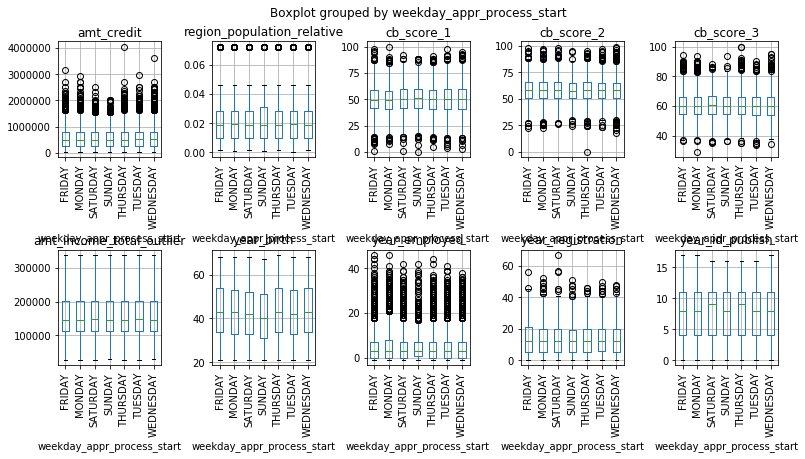

In [90]:
cat_num_boxplot(df_eda, 'weekday_appr_process_start', num_col)

➡ 요일별로 연속형 컬럼을 확인했을 때, 유의미한 결과가 보이지 않음

##### - hour_appr_process_start (대출신청시간)

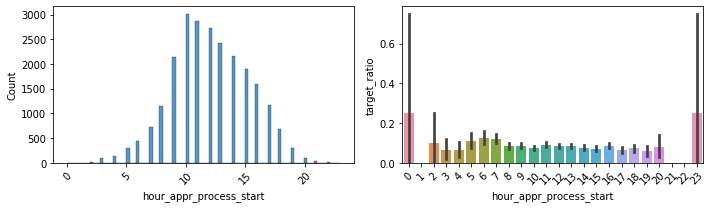

In [91]:
cat_col_plt(df_eda, 'hour_appr_process_start')

➡ 새벽 연체율이 높아보이나 모수가 적어서 나타나는 현상 같기도 함<br>
➡ 시간별로 연체율이 큰 차이는 없어보이나, 시간의 유효값이 24개로 많기 때문에 근무시간(9-18)/근무시간 외로 나눠서 활용해보려고함

##### ** working_hour (근무시간 여부)

In [92]:
#working hour 분류
df_eda['working_hour'] = df_eda['hour_appr_process_start'].apply(lambda x: 'Y' if x <= 18 and x >= 9 else 'N')

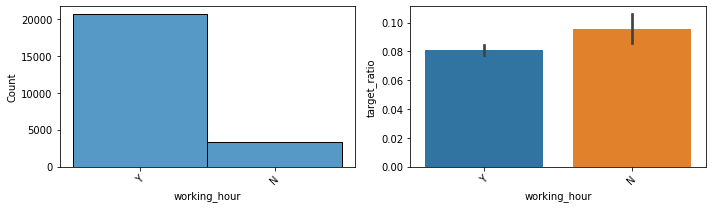

In [93]:
cat_col_plt(df_eda, 'working_hour')

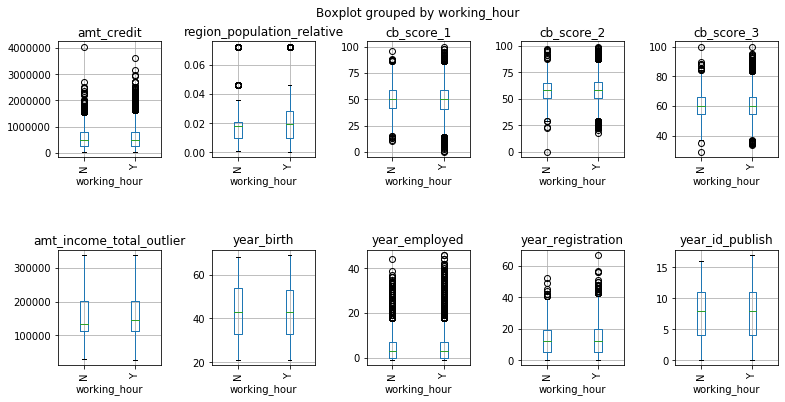

In [94]:
cat_num_boxplot(df_eda, 'working_hour', num_col)

➡ 근무시간 외 시간에 대출을 신청한 고객이 근무시간에 대출을 신청한 고객보다 target ratio가 높음 <br>
➡ 근무시간 외 시간에 대출을 신청한 고객이 좀 더 불안정한 일자리를 가지고 있는 고객일 수도 있겠다는 생각이 들었음

##### - amt_credit (대출금액)

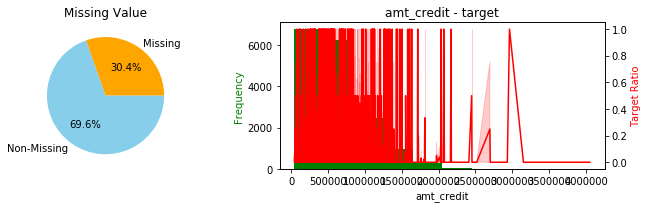

In [95]:
num_col_plt(df_eda, 'amt_credit')

➡ 금액별로 크게 차이는 없어보이지만, 소득금액과 마찬가지로 구간을 나눠서 보는 것이 좋을 듯 함<br>

In [96]:
tmp = df_eda.copy()

In [97]:
bin_width = 50000
tmp['amt_credit_bins'] = pd.cut(df_eda['amt_credit'], 
                                             bins=np.arange(df_eda['amt_credit'].min(), 
                                                            df_eda['amt_credit'].max() + bin_width, 
                                                            bin_width),
                                             right=False)  # right=False로 설정하면 왼쪽 포함, 오른쪽 미포함 구간

# 중간값(평균) 계산하여 새로운 컬럼에 할당
tmp['amt_credit_mean'] = tmp['amt_credit_bins'].apply(lambda x: (x.left + x.right) / 2)

# 결과 확인
print(tmp[['amt_credit_bins', 'amt_credit_mean']].head(2))


       amt_credit_bins amt_credit_mean
0                  NaN             NaN
1  [95000.0, 145000.0)        120000.0


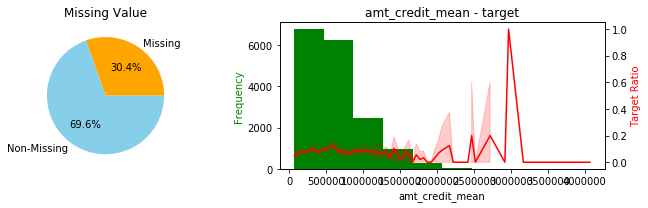

In [98]:
num_col_plt(tmp, 'amt_credit_mean')

➡ 신용대출금액별로 연체율에 차이가 있어보이진 않음<br>
➡ 다만, 숫자형 컬럼의 상관관계를 확인했을 때 신용대출금액의 cb_score_2와 소득금액과의 상관관계각 각각 -0.37, 0.41로 나름 연관이 있으니 해당 컬럼을 이용해서 결측을 채워보면 좋을 것 같음

---

#### 3) 대출 신청 관련 고객 등록정보/제공정보

##### - days_registration, id_publish (등록정보, 신분증 변경시점)
    - days 컬럼은 year로 변경하여 확인함

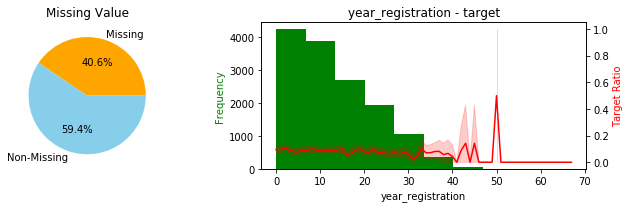

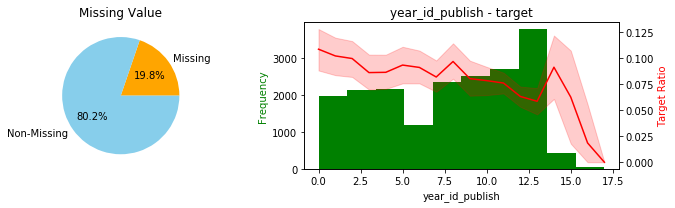

In [99]:
num_col_plt(df_eda, 'year_registration')
num_col_plt(df_eda, 'year_id_publish')

➡ year_registration의 경우 기간 별 연체와의 연관은 적으나, cb_score_2와 year_birth와 각각 0.56, 0.33의 상관관계를 보임<br>
➡ year_id_publish는 기간이 길수록(신분증을 변경한 기간이 오래됐을수록) 연체율이 낮음. 나이와 관련이 있을 수 있다고 보여짐<br>
➡ 두 컬럼 모두 삭제하는 대신 연관이 있는 연속형변수를 활용하여 결측치 처리 예정

##### - 연락처/이메일 등록여부 (5개 컬럼)

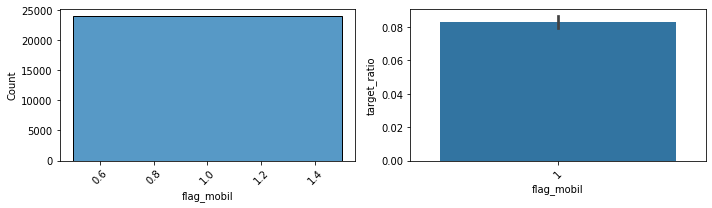

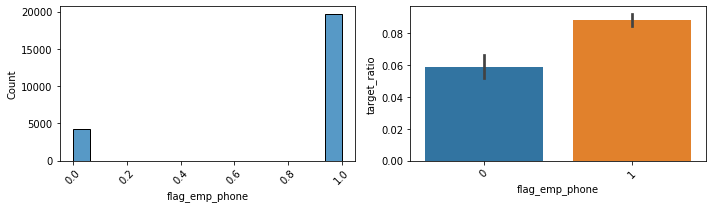

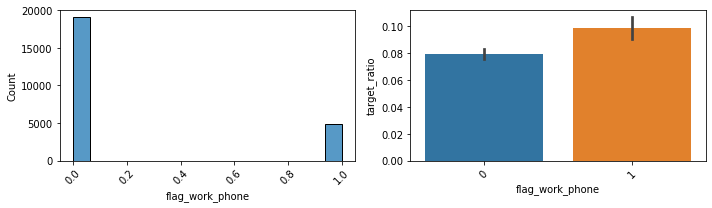

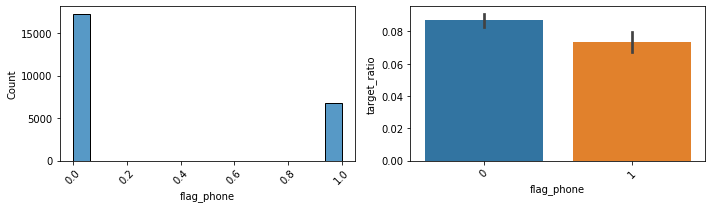

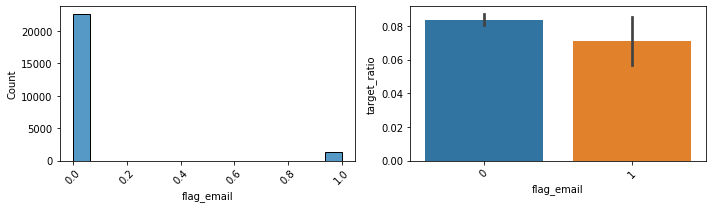

In [100]:
cat_col_plt(df_eda, 'flag_mobil') #휴대폰번호 등록여부
cat_col_plt(df_eda, 'flag_emp_phone') #고용주 연락처 등록여부
cat_col_plt(df_eda, 'flag_work_phone') #직장전화번호 등록여부 
cat_col_plt(df_eda, 'flag_phone') #집 전화번호 등록여부
cat_col_plt(df_eda, 'flag_email') #이메일 주소 등록 여부

➡ flag_mobil은 전체 고객이 등록했기 때문에 무의미한 컬럼. 삭제.<br>
➡ 나머지 컬럼은 등록/미등록 간 건수 차이가 꽤 나는데도 연체율이 비슷한 수준을 보이고 있지만, 컬럼별로 등록여부에 따라 달라지고 있으니 활용해보려고함

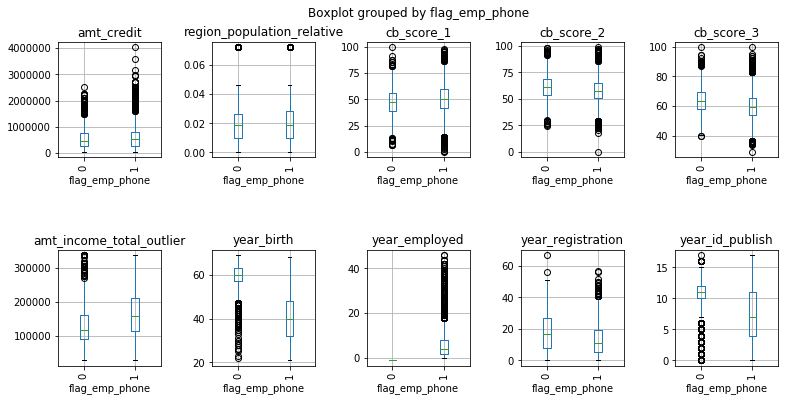

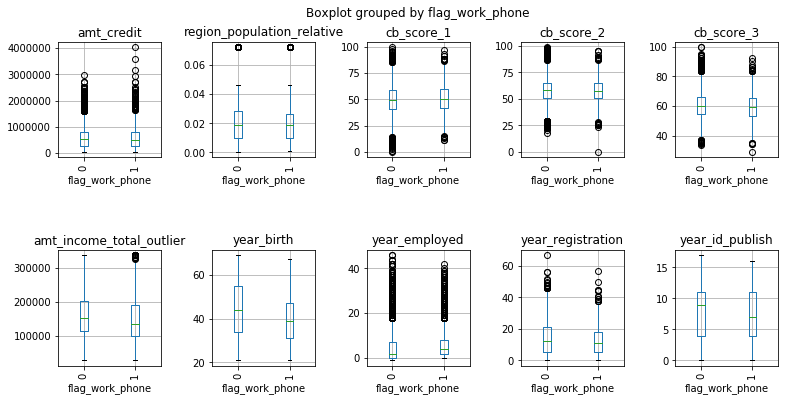

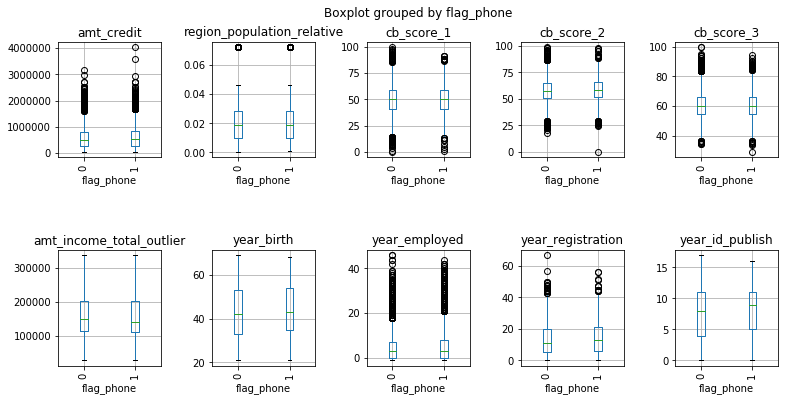

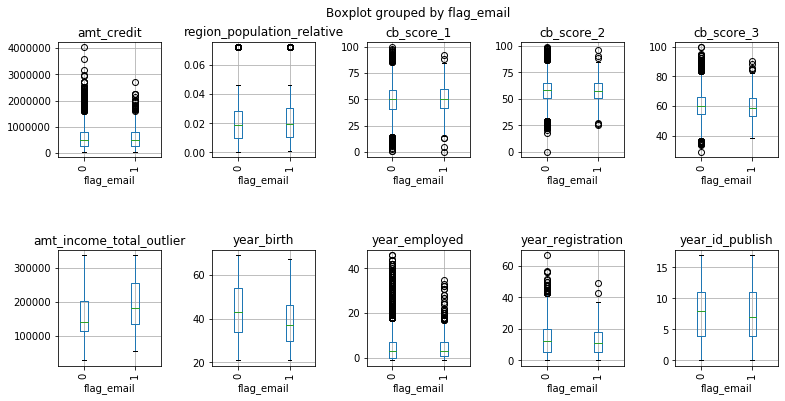

In [101]:
#flag_mobil 외 등록여부 컬럼에 대한 연속형 변수의 박스플랏 확인
cat_num_boxplot(df_eda, 'flag_emp_phone', num_col)
cat_num_boxplot(df_eda, 'flag_work_phone', num_col)
cat_num_boxplot(df_eda, 'flag_phone', num_col)
cat_num_boxplot(df_eda, 'flag_email', num_col)

##### - 주소지 일치여부 (3개 컬럼)
    - 컬럼명이 ~not~ 이기 때문에 0을 일치, 1을 불일치로 봄

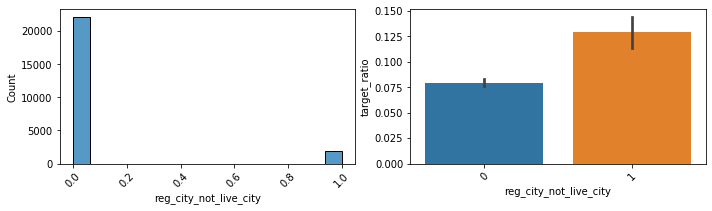

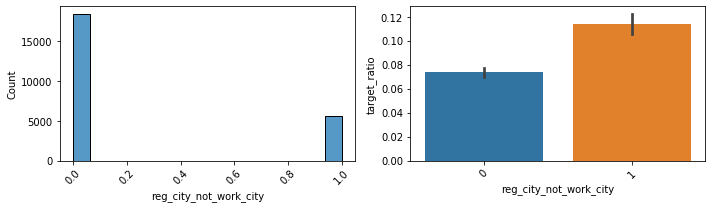

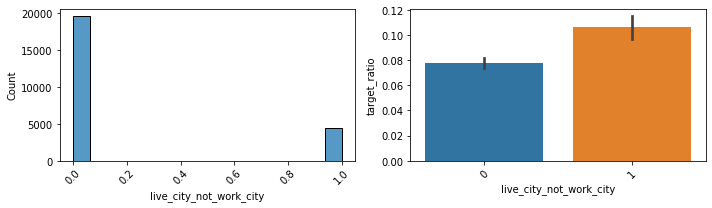

In [102]:
cat_col_plt(df_eda, 'reg_city_not_live_city')
cat_col_plt(df_eda, 'reg_city_not_work_city')
cat_col_plt(df_eda, 'live_city_not_work_city')

➡ 전반적으로 주소가 일치하는 사람(0)이 연체율이 낮음. <br>
➡ 일치 수에 대한 파생변수를 만들어 보는 것도 괜찮을 듯

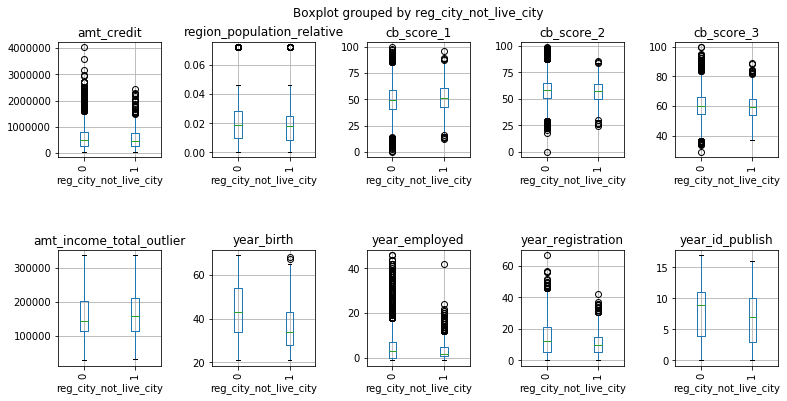

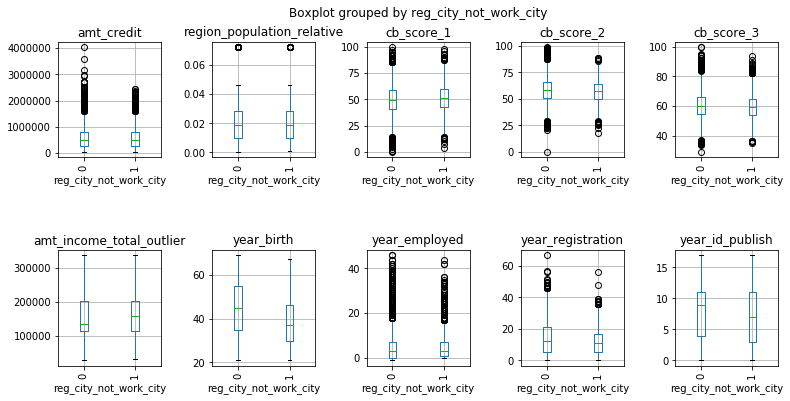

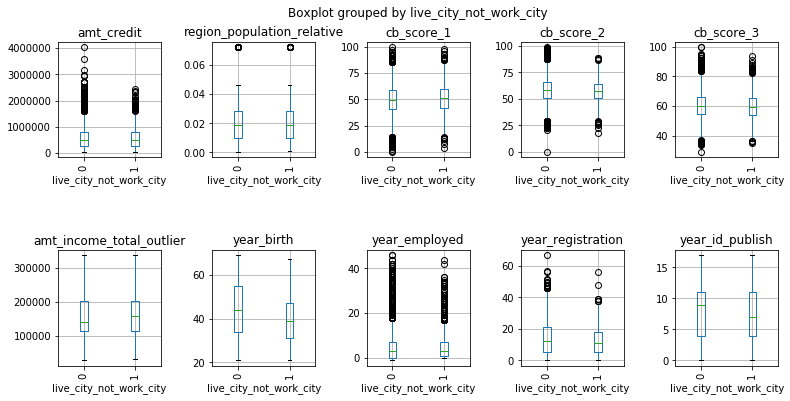

In [103]:
cat_num_boxplot(df_eda, 'reg_city_not_live_city', num_col)
cat_num_boxplot(df_eda, 'reg_city_not_work_city', num_col)
cat_num_boxplot(df_eda, 'live_city_not_work_city', num_col)

➡ 주소가 일치하는 사람(0)이 일치하지 않는 사람(1)보다 연령이 높음 <br>
➡ 연속형 변수의 분포를 비교했을 때 주소지 일치여부 컬럼 3개는 비슷한 분포를 보임
- 3개 컬럼의 분포가 비슷하기 때문에 주소 일치수 관련 파생변수를 만들어 보는 것도 괜찮아보임

##### ** city_diff (주소 불일치 수)

In [104]:
#불일치 갯수 카운트 컬럼 생성
df_eda['city_diff'] = df_eda[['reg_city_not_live_city', 'reg_city_not_work_city', 'live_city_not_work_city']].eq(1).sum(axis=1)

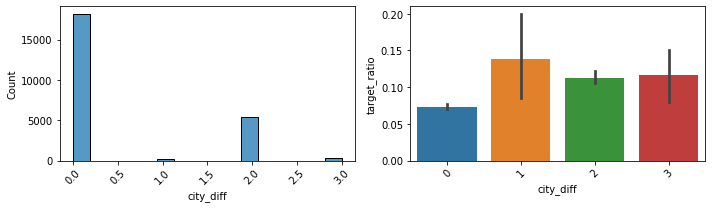

In [105]:
cat_col_plt(df_eda, 'city_diff')

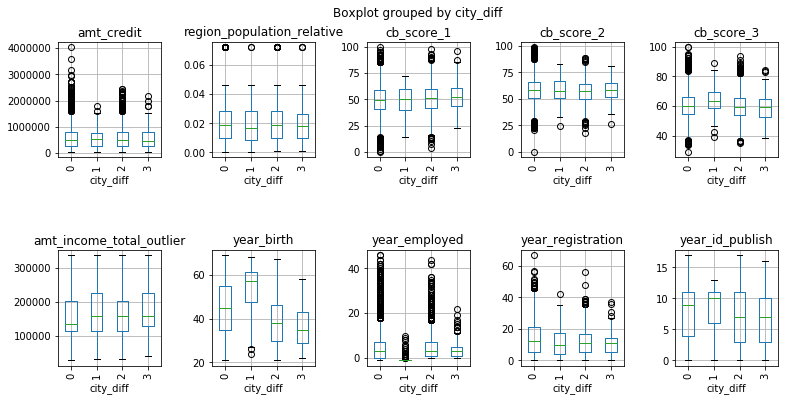

In [106]:
cat_num_boxplot(df_eda, 'city_diff', num_col)

➡ 일치여부를 각각 볼 때보다 차이가 보임 <br>
➡ 등록지 주소와 실거주지와 직장주소가 모두 일치하는 고객이 연체 가능성이 낮음

##### - flag_document_2,3,4 (문서2,3,4 제공여부)

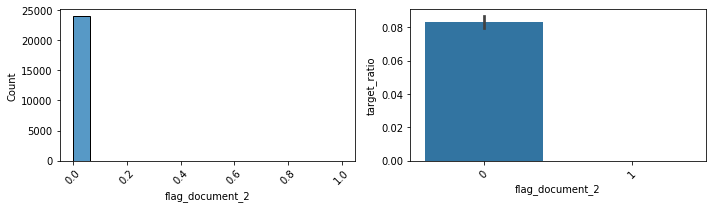

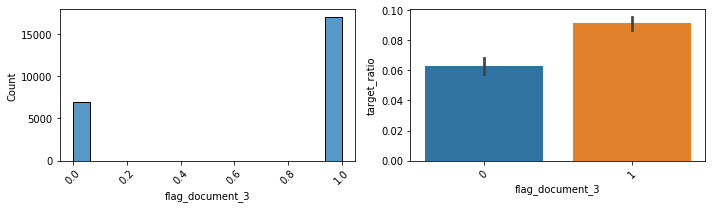

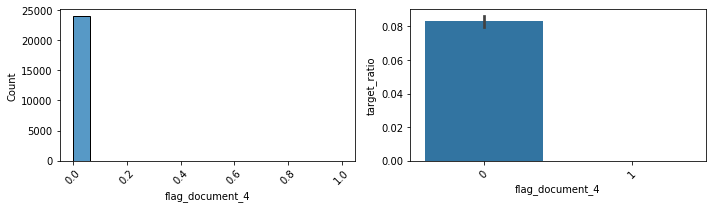

In [107]:
cat_col_plt(df_eda, 'flag_document_2')
cat_col_plt(df_eda, 'flag_document_3')
cat_col_plt(df_eda, 'flag_document_4')

In [108]:
print(df_eda['flag_document_2'].value_counts())
print(df_eda['flag_document_4'].value_counts())

0    23996
1        4
Name: flag_document_2, dtype: int64
0    23997
1        3
Name: flag_document_4, dtype: int64


➡ 문서 2와 4는 제출한 사람이 너무 적음 <br>

In [109]:
#고객별로 문서를 몇개나 제출했는 지 확인
tmp = df_eda.copy()
tmp['doc_submit'] = tmp[['flag_document_2', 'flag_document_3', 'flag_document_4']].eq(1).sum(axis=1)

tmp['doc_submit'].value_counts()

1    17030
0     6970
Name: doc_submit, dtype: int64

➡ 문서 세 개 중 하나를 제출하거나, 아무것도 제출하지 않거나 두 그룹으로 나뉘어짐. 대상 건이 적은 문서 2, 4는 삭제

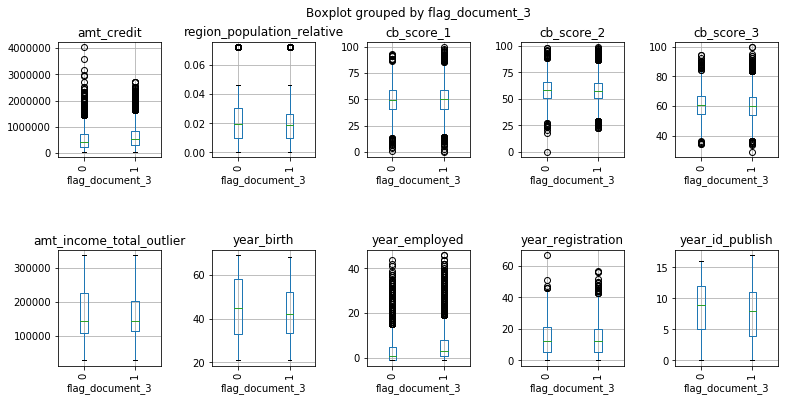

In [110]:
cat_num_boxplot(df_eda, 'flag_document_3', num_col)

문서3과 연속형 컬럼들 사이의 분포 확인  <br>
➡ 문서3을 제출한 사람이 미제출자보다 대출금액이 조금 더 크고 나이가 어리나, 큰 차이는 없음

##### - cb_score_1,2,3 (신용점수 1,2,3) ✔️

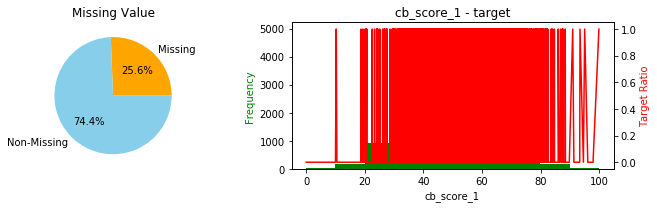

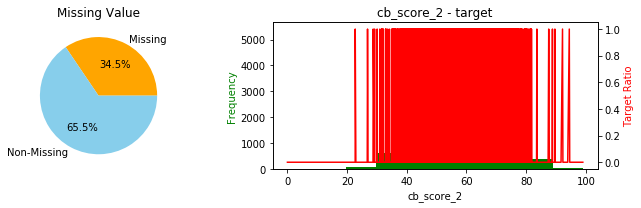

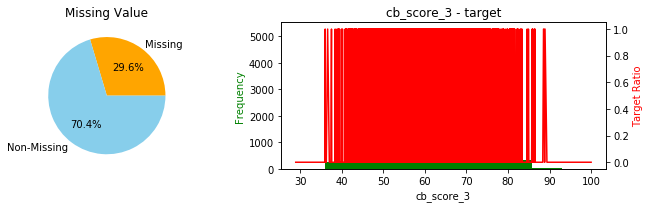

In [111]:
num_col_plt(df_eda, 'cb_score_1')
num_col_plt(df_eda, 'cb_score_2')
num_col_plt(df_eda, 'cb_score_3')

➡ 구간 나눠서 다시 확인

In [112]:
tmp = df_eda.copy()

In [113]:
tmp[['cb_score_1','cb_score_2','cb_score_3']].describe()

,cb_score_1,cb_score_2,cb_score_3
count,17854.000000,15726.000000,16892.000000
mean,49.942357,58.061950,60.368432
std,13.095990,10.752802,8.682502
min,0.000000,0.000000,28.967147
25%,41.026337,50.801249,54.410659
50%,49.894802,57.935604,59.971539
75%,58.919900,65.184718,66.097419
max,99.870790,98.987986,100.000000


In [114]:
bin_width = 10
tmp['cb_1_bins'] = pd.cut(df_eda['cb_score_1'], bins=np.arange(df_eda['cb_score_1'].min(), 
                                                            df_eda['cb_score_1'].max() + bin_width, 
                                                            bin_width), right=False)
tmp['cb_2_bins'] = pd.cut(df_eda['cb_score_2'], bins=np.arange(df_eda['cb_score_2'].min(), 
                                                            df_eda['cb_score_2'].max() + bin_width, 
                                                            bin_width), right=False)
tmp['cb_3_bins'] = pd.cut(df_eda['cb_score_3'], bins=np.arange(df_eda['cb_score_3'].min(), 
                                                            df_eda['cb_score_3'].max() + bin_width, 
                                                            bin_width), right=False)

# 중간값(평균) 계산하여 새로운 컬럼에 할당
tmp['cb_1_mean'] = tmp['cb_1_bins'].apply(lambda x: (x.left + x.right) / 2)
tmp['cb_2_mean'] = tmp['cb_2_bins'].apply(lambda x: (x.left + x.right) / 2)
tmp['cb_3_mean'] = tmp['cb_3_bins'].apply(lambda x: (x.left + x.right) / 2)


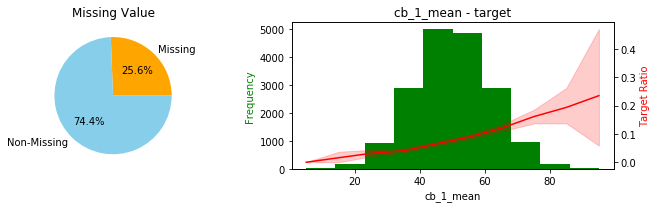

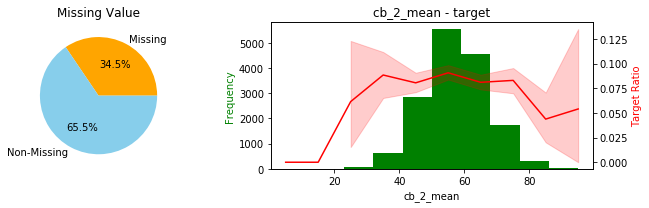

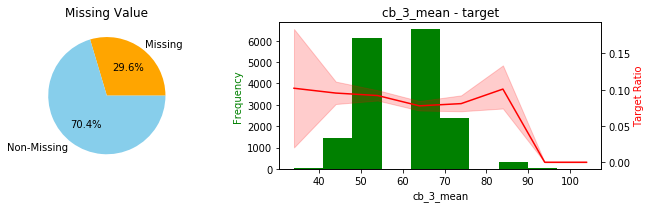

In [115]:
num_col_plt(tmp, 'cb_1_mean')
num_col_plt(tmp, 'cb_2_mean')
num_col_plt(tmp, 'cb_3_mean')

➡ cb score 1,2,3 모두 점수와 연체간 약간의 관계가 있는 듯 보여짐<br>
➡ 신기한건 일반적으로 신용점수가 높은 고객이 연체를 안 한다고 생각하는데 cb score_1의 경우에는 신용점수가 높아질수록 target ratio가 높아짐 <br>
➡ 연체 예측에 필요한 항목이라고 생각되어 삭제하지 않고 결측처리를 해보려함 

---

### 1-4. 데이터 결측값 대체 (다중대체, 차원축소, 클러스터링)

<b>☑️ 데이터 결측값 대체 및 클러스터링 순서 </b><br>

<b>1️⃣ 연속형 변수 (7개 컬럼) 다중대체 <br></b>
    - 결측값이 존재하는 연속형 변수(7개)와 관련이 있어보이는 8개 컬럼을 이용해서 다중대체 수행 <br>
    * cb_score_1, 3은 연속형 변수들과 관련이 없어보여서 차원축소, 클러스터링 수행 후 처리함<br>
    <br>
    
<b>2️⃣ 직장유형, 소득유형, 학력 컬럼을 PCA(차원축소) 후 k-means 클러스터링 <br></b>
    - 학력 컬럼은 소득금액, 나이, 연체와도 관련있는 유의미한 컬럼으로 보이므로 직장유형, 소득유형과 함께 차원축소 진행 <br>
    <br>
    
<b>3️⃣ 연속형 변수 (2개 컬럼 - cb_score_1, cb_score_3) 다중대체 <br></b>
    - cb_score_1,3 컬럼을 나이, 자녀수, seg1,2,3,4 컬럼을 이용해서 다중대체 수행 (최대한 관련이 있어 보이는 변수 활용함)<br>
    <br>
    
<b>4️⃣ 직장유형 추가 k-means 클러스터링<br></b>
    - 유효값이 58개인 직장유형을 전체 연속형 변수를 활용하여 군집화 진행 <br>
    - 2️⃣번과는 별개로 전체 연속형 변수를 활용하여 클러스터링 진행 (k-means가 연속형 변수에 더 성능이 좋다고 함)
<br>

In [116]:
#분석용 df 생성

df_anal = df_eda[['sk_id_curr', 'code_gender', 'cnt_children', 'child_yn'
                , 'amt_income_total_outlier', 'amt_credit'
                , 'name_contract_type','organization_type', 'name_income_type', 'is_pensioner', 'name_education_type'
                , 'name_family_status', 'housing_group'# 'name_housing_type'
                , 'region_rating_client','region_population_relative'
                , 'reg_city_not_work_city', 'live_city_not_work_city', 'reg_city_not_live_city', 'city_diff'
                , 'year_birth', 'year_employed', 'year_registration', 'year_id_publish'
                , 'days_birth','days_employed','days_registration','days_id_publish'
                , 'cb_score_1', 'cb_score_2', 'cb_score_3'
                , 'flag_own_realty','flag_document_3'          
                , 'working_hour'
                #, 'weekday_appr_process_start', 'hour_appr_process_start'
                , 'flag_emp_phone','flag_work_phone', 'flag_phone', 'flag_email','target']]  

In [117]:
df_anal.head(2)

,sk_id_curr,code_gender,cnt_children,child_yn,amt_income_total_outlier,amt_credit,name_contract_type,organization_type,name_income_type,is_pensioner,name_education_type,name_family_status,housing_group,region_rating_client,region_population_relative,reg_city_not_work_city,live_city_not_work_city,reg_city_not_live_city,city_diff,year_birth,year_employed,year_registration,year_id_publish,days_birth,days_employed,days_registration,days_id_publish,cb_score_1,cb_score_2,cb_score_3,flag_own_realty,flag_document_3,working_hour,flag_emp_phone,flag_work_phone,flag_phone,flag_email,target
0,100002,M,0,N,202500.0,NaN,Cash loans,Business Entity Type 3,Working,N,Secondary / secondary special,Single / not married,A,2,0.018801,0,0,0,0,25.0,1.0,9.0,5.0,-9461.0,-637.0,-3648.0,-2120.0,NaN,NaN,58.349224,Y,1,Y,1,0,1,0,1
1,100004,Null,0,N,67500.0,135000.0,Revolving loans,Government,Working,N,Secondary / secondary special,Single / not married,A,2,NaN,0,0,0,0,52.0,NaN,11.0,6.0,-19046.0,NaN,-4260.0,-2531.0,26.499494,57.600542,46.433666,Null,0,Y,1,1,1,0,0


In [118]:
ohe_col = ['code_gender', 'child_yn','name_contract_type', 'is_pensioner','reg_city_not_live_city', 'reg_city_not_work_city', 'live_city_not_work_city', 'flag_own_realty', 'name_family_status','housing_group', 'working_hour'] 

df_anal = ohe(df_anal, ohe_col)

In [119]:
# 시드 설정
seed_value = 42

In [120]:
scorer = make_scorer(roc_auc_score)

#### 1) 연속형 변수 (7개 컬럼) 다중대체 

- 다중대체 컬럼 (7개 컬럼) : days_birth, days_registration, days_id_publish, cb_score_2, amt_credit, region_population_relative
- 다중대체 시, 사용 컬럼(5개 컬럼) : city_diff, housing_group, child_yn, is_pensioner, amt_income_total_outlier

In [121]:
st = datetime.now()

imputer_col = df_anal[['days_birth','days_employed','days_registration','days_id_publish'
                       , 'cb_score_2','amt_income_total_outlier','amt_credit','region_population_relative'
                       , 'city_diff'
                       , 'housing_group_A','housing_group_B'
                       , 'child_yn_N', 'child_yn_Y', 'is_pensioner_N', 'is_pensioner_Y']]

n_iterations = 5
imputer = IterativeImputer(estimator=RandomForestRegressor(random_state = seed_value), max_iter=n_iterations)
imputed = imputer.fit_transform(imputer_col)

print(datetime.now() - st)

0:07:35.158596


In [122]:
imputed = pd.DataFrame(imputed, columns=imputer_col.columns)

In [123]:
cols = ['days_birth','days_employed','days_registration','days_id_publish'
                       , 'cb_score_2','amt_credit','region_population_relative']

In [124]:
# 컬럼명 변경 (기존 컬럼명 뒤에 '_imp'를 붙임)
imputed_col = [col + '_imp' for col in cols]

df_anal[imputed_col] = imputed[cols]

In [125]:
# days 관련 변수에 대해 함수 적용
transform_and_divide_continuous_variable(df_anal, 'days_birth_imp')
transform_and_divide_continuous_variable(df_anal, 'days_employed_imp')
transform_and_divide_continuous_variable(df_anal, 'days_registration_imp')
transform_and_divide_continuous_variable(df_anal, 'days_id_publish_imp')

#컬럼명 변경
new_column_names = {
    'days_birth_imp_y': 'year_birth_imp',
    'days_employed_imp_y': 'year_employed_imp',
    'days_registration_imp_y': 'year_registration_imp',
    'days_id_publish_imp_y': 'year_id_publish_imp'
}
df_anal.rename(columns=new_column_names, inplace=True)

#### 2) 직장유형, 소득유형, 학력 컬럼 PCA(차원축소)/k-means 클러스터링 

##### - 직장유형, 소득유형, 학력 PCA(차원축소)

In [126]:
scale_col = ['year_birth_imp', 'year_employed_imp','year_registration_imp', 'year_id_publish_imp'
             # 'days_birth_imp','days_employed_imp','days_registration_imp','days_id_publish_imp'
            , 'cb_score_2_imp','amt_income_total_outlier','amt_credit_imp']

#z_score scailing
Z = df_anal[scale_col]

Z_scaler = StandardScaler()

Z_scaler.fit(Z)
Z_scaled = Z_scaler.transform(Z)

Z_scaled_df = pd.DataFrame(Z_scaled, columns=scale_col)

In [127]:
pca_cols = Z_scaled_df.copy()
pca_cols['education_type'] = df_eda['name_education_type']
pca_cols['income_type'] = df_eda['name_income_type']
pca_cols['organization_type'] = df_eda['organization_type']

In [128]:
pca_cols = ohe(pca_cols, ['education_type','income_type', 'organization_type'])

In [129]:
pca_cols.head(2)

,year_birth_imp,year_employed_imp,year_registration_imp,year_id_publish_imp,cb_score_2_imp,amt_income_total_outlier,amt_credit_imp,education_type_Academic degree,education_type_Higher education,education_type_Incomplete higher,education_type_Lower secondary,education_type_Secondary / secondary special,income_type_Businessman,income_type_Commercial associate,income_type_Maternity leave,income_type_Pensioner,income_type_State servant,income_type_Student,income_type_Working,organization_type_Advertising,organization_type_Agriculture,organization_type_Bank,organization_type_Business Entity Type 1,organization_type_Business Entity Type 2,organization_type_Business Entity Type 3,organization_type_Cleaning,organization_type_Construction,organization_type_Culture,organization_type_Electricity,organization_type_Emergency,organization_type_Government,organization_type_Hotel,organization_type_Housing,organization_type_Industry: type 1,organization_type_Industry: type 10,organization_type_Industry: type 11,organization_type_Industry: type 12,organization_type_Industry: type 13,organization_type_Industry: type 2,organization_type_Industry: type 3,organization_type_Industry: type 4,organization_type_Industry: type 5,organization_type_Industry: type 6,organization_type_Industry: type 7,organization_type_Industry: type 8,organization_type_Industry: type 9,organization_type_Insurance,organization_type_Kindergarten,organization_type_Legal Services,organization_type_Medicine,organization_type_Military,organization_type_Mobile,organization_type_Other,organization_type_Police,organization_type_Postal,organization_type_Realtor,organization_type_Religion,organization_type_Restaurant,organization_type_School,organization_type_Security,organization_type_Security Ministries,organization_type_Self-employed,organization_type_Services,organization_type_Telecom,organization_type_Trade: type 1,organization_type_Trade: type 2,organization_type_Trade: type 3,organization_type_Trade: type 4,organization_type_Trade: type 5,organization_type_Trade: type 6,organization_type_Trade: type 7,organization_type_Transport: type 1,organization_type_Transport: type 2,organization_type_Transport: type 3,organization_type_Transport: type 4,organization_type_University,organization_type_XNA
0,-1.591476,-0.656223,-0.480536,-0.684297,0.231854,0.546285,-0.619097,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.744889,0.891271,-0.250226,-0.429603,-0.057237,-1.286959,-1.245348,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [130]:
#차원축소
pca = PCA(n_components=0.95, random_state=seed_value)

pca_result = pca.fit_transform(pca_cols)

cols = []
for i in range(pca_result.shape[1]):
    col = 'PCA_'+str(i+1)
    cols.append(col)

pca_df = pd.DataFrame(data=pca_result, columns = cols)
print(pca_df.head())

      PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0  0.861790 -1.445307  0.310458 -0.888707 -0.823031  0.130772 -0.800902   
1 -0.736860 -1.131363  0.210839  1.325117  1.057739 -0.587554 -0.227989   
2 -0.479540 -0.728480  0.118923  0.535589 -0.483773  0.867272 -0.333251   
3  2.053645 -1.088366 -0.746585  0.006719  0.432880  0.591296 -0.507222   
4  1.434514 -0.854915 -0.058864 -1.039410  0.770729 -0.492191 -0.788341   

      PCA_8     PCA_9    PCA_10    PCA_11    PCA_12    PCA_13    PCA_14  \
0  0.025743  0.482693  0.093402 -0.399757 -0.230003  0.089044 -0.032092   
1  0.256555  0.090115 -0.196519  0.127075  0.347159 -0.078815 -0.176869   
2  0.094750 -0.261311  0.187274 -0.116978  0.198225 -0.127120 -0.202522   
3  0.032594  0.583156  0.354653 -0.285639 -0.175113  0.094063 -0.011314   
4  0.249102 -0.192805  0.066772  0.010611  0.251732 -0.133332 -0.095461   

     PCA_15  
0 -0.096590  
1  0.160127  
2  0.109397  
3 -0.070802  
4  0.038946  


In [131]:
# 설명된 분산의 비율
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)

[0.24139608 0.17325296 0.1428369  0.09934203 0.08202012 0.05910332
 0.03964488 0.03226193 0.02082067 0.01974375 0.01481812 0.00960369
 0.00848355 0.00550898 0.00540473]


In [132]:
# 누적 분산
cumulative_variance_ratio = explained_variance_ratio.cumsum()
print(cumulative_variance_ratio)

[0.24139608 0.41464904 0.55748593 0.65682797 0.73884809 0.79795142
 0.8375963  0.86985823 0.8906789  0.91042265 0.92524077 0.93484446
 0.94332801 0.948837   0.95424172]


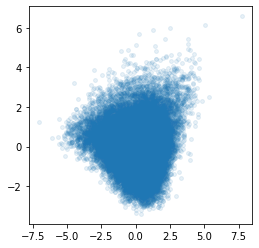

In [133]:
plt.figure(figsize = (4,4))
plt.scatter(pca_df.iloc[:,0], pca_df.iloc[:,1], alpha = 0.1, s = 15)
plt.show()

<BarContainer object of 15 artists>

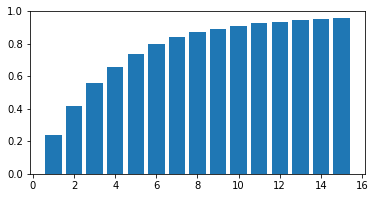

In [134]:
plt.figure(figsize=(6, 3))
plt.bar(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, align='center')

Loading Value

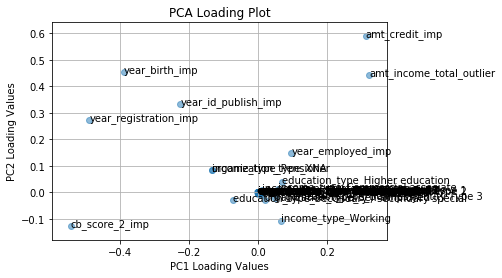

In [135]:
# 주성분(PC)과 변수들 간의 로딩 값 (계수) 가져오기
loading_values = pca.components_

# 변수 이름 (특성 이름) 가져오기
feature_names = pca_cols.columns

# Loading Plot 그리기
plt.figure(figsize=(6, 4))
plt.scatter(loading_values[0], loading_values[1], alpha=0.5)
plt.xlabel("PC1 Loading Values")
plt.ylabel("PC2 Loading Values")
plt.title("PCA Loading Plot")

# 각 변수에 대한 이름 추가
for i, feature_name in enumerate(feature_names):
    plt.annotate(feature_name, (loading_values[0, i], loading_values[1, i]))

plt.grid(True)
plt.show()

In [136]:
#PC 1
pd.DataFrame({'Feature': feature_names, 'Loading Value': loading_values[0]}).sort_values(by = 'Loading Value', ascending=False)

,Feature,Loading Value
5,amt_income_total_outlier,0.320720
6,amt_credit_imp,0.311221
1,year_employed_imp,0.096067
8,education_type_Higher education,0.067803
18,income_type_Working,0.065099
...,...,...
15,income_type_Pensioner,-0.133779
3,year_id_publish_imp,-0.225435
0,year_birth_imp,-0.387984
2,year_registration_imp,-0.489010


In [137]:
# PC 2
pd.DataFrame({'Feature': feature_names, 'Loading Value': loading_values[1]}).sort_values(by = 'Loading Value', ascending=False)

,Feature,Loading Value
6,amt_credit_imp,0.589714
0,year_birth_imp,0.452795
5,amt_income_total_outlier,0.441983
3,year_id_publish_imp,0.331806
2,year_registration_imp,0.271396
...,...,...
24,organization_type_Business Entity Type 3,-0.022878
61,organization_type_Self-employed,-0.027104
11,education_type_Secondary / secondary special,-0.029391
18,income_type_Working,-0.106082


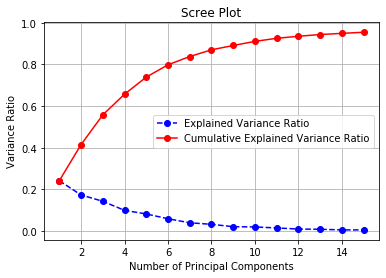

In [138]:
#Scree plot
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color='b', label='Explained Variance Ratio')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', color='r', label='Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Ratio')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

##### - 주성분 6개 K-means 클러스터링

In [139]:
# fit(pca_df) -> fit(pca_df.iloc[:,:6] 로 바꿈. 주성분 6개만 선택해서 다시 진행)
dist = []
for i in range(1,10):
    st = time.time()
    kmeans = KMeans(i, init = 'k-means++', random_state = seed_value)
    kmeans.fit(pca_df.iloc[:,:6])
    dist.append(kmeans.inertia_)

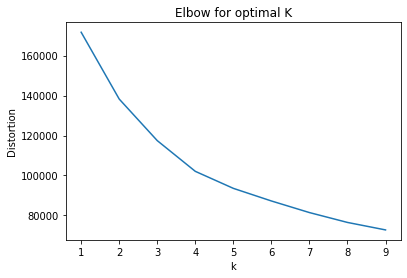

In [140]:
plt.figure(figsize = (6,4))
plt.plot(range(1,10), dist)
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow for optimal K')
plt.show()

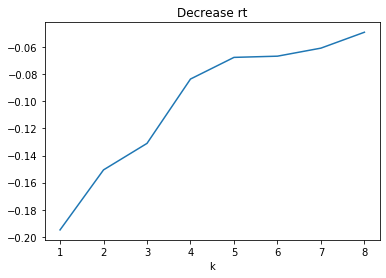

In [141]:
plt.figure(figsize = (6,4))
rt = pd.DataFrame(dist).pct_change()
plt.plot(rt)
plt.xlabel('k')
plt.title('Decrease rt')
plt.show()

In [142]:
k = 4

kmeans = KMeans(n_clusters=k, random_state=seed_value)
kmeans.fit(pca_df.iloc[:,:6])
labels = kmeans.predict(pca_df.iloc[:,:6])
knn_pca_df = pd.DataFrame(pca_df.iloc[:,:6])
knn_pca_df.loc[:,'label'] = labels

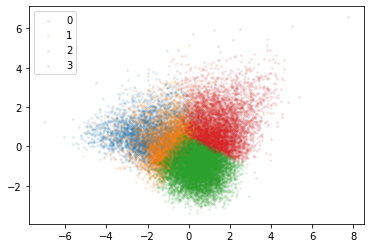

In [143]:
plt.figure(figsize = (6,4))
for i in range(k):
    knn_seg_df = knn_pca_df.loc[knn_pca_df['label'] == i]
    plt.scatter(knn_seg_df.iloc[:,0], knn_seg_df.iloc[:,1], label = i, s = 3, alpha = 0.1)
    plt.legend()
plt.show()  

In [144]:
knn_pca_df['label'].value_counts()

2    9314
3    5366
1    5130
0    4190
Name: label, dtype: int64

In [145]:
df_anal['seg'] = knn_pca_df['label']

In [146]:
df_anal = ohe(df_anal, 'seg')

In [147]:
df_anal = ohe(df_anal, ['flag_document_3', 'flag_emp_phone','flag_work_phone', 'flag_phone', 'flag_email'])

#### 3) 연속형 변수 (2개 컬럼) 다중대체 

- 다중대체 컬럼(2개 컬럼) : cb_score_1, cb_score_3
- 다중대체 시, 사용 컬럼(3개 컬럼) : days_birth_imp, seg, cnt_children

In [148]:
st = datetime.now()

cb_imputer = df_anal[['days_birth_imp','cb_score_1','cb_score_3','seg_0','seg_1','seg_2','seg_3','cnt_children']]

n_iterations = 5
imputer = IterativeImputer(estimator=RandomForestRegressor(random_state = seed_value), max_iter=n_iterations)
cb_imputed = imputer.fit_transform(cb_imputer)

print(datetime.now() - st)

0:02:14.682359


In [149]:
cb_imputed = pd.DataFrame(cb_imputed, columns=cb_imputer.columns)

In [150]:
# df_anal 에 결측값 채워진 컬럼적용
df_anal['cb_score_1_imp'] = cb_imputed['cb_score_1']
df_anal['cb_score_3_imp'] = cb_imputed['cb_score_3']

#### 4) 직장유형 추가 k-means 클러스터링

In [151]:
# 표준화할 변수들을 선택합니다. -> 연속형 변수 선택
selected_columns = ['amt_income_total_outlier', 'amt_credit_imp', 'region_population_relative_imp', 'days_birth_imp',
                    'days_employed_imp', 'days_registration_imp', 'days_id_publish_imp', 'cb_score_1_imp',
                    'cb_score_2_imp', 'cb_score_3_imp']

# 데이터프레임에서 선택한 변수들만 추출합니다.
selected_data = df_anal[selected_columns]

In [153]:
scaler = StandardScaler()

standardized_data = scaler.fit_transform(selected_data)
standardized_df = pd.DataFrame(standardized_data, columns=selected_columns)

print(standardized_df.head())

   amt_income_total_outlier  amt_credit_imp  region_population_relative_imp  \
0                  0.546285       -0.619097                       -0.190358   
1                 -1.286959       -1.245348                       -0.208967   
2                 -0.736985       -0.230343                       -0.204145   
3                 -0.370337        0.456799                        0.436344   
4                  0.546285        0.025843                       -0.985067   

   days_birth_imp  days_employed_imp  days_registration_imp  \
0        1.554959           0.639122               0.423238   
1       -0.717363          -0.810322               0.230226   
2        0.732324          -0.035355              -0.040086   
3        1.122305           0.586942               1.539680   
4        0.377249           0.716673               0.969437   

   days_id_publish_imp  cb_score_1_imp  cb_score_2_imp  cb_score_3_imp  
0             0.603838        0.164589        0.231854       -0.269640  


In [154]:
label_encoder = LabelEncoder()
standardized_df['organization_type_encoded'] = label_encoder.fit_transform(df_anal['organization_type'])	

In [155]:
k_values = range(1, 11)

wcss_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=seed_value)
    kmeans.fit(standardized_df)  # 데이터프레임 df에 대해 K-Means 수행
    wcss_values.append(kmeans.inertia_)  # WCSS 값을 리스트에 추가

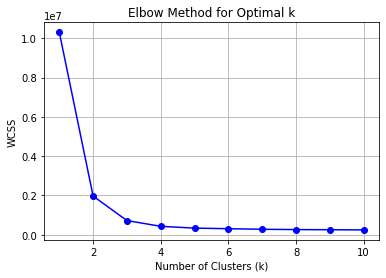

In [156]:
# WCSS 값을 그래프로 시각화
plt.figure(figsize=(6, 4))
plt.plot(k_values, wcss_values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [157]:
k = 3

kmeans = KMeans(n_clusters=k, random_state=seed_value)
kmeans.fit(standardized_df)
wcss_values.append(kmeans.inertia_)
labels = kmeans.predict(standardized_df)

In [158]:
standardized_df['cluster'] = labels

In [159]:
standardized_df['cluster'] = standardized_df['cluster'].astype(object)

In [160]:
df_anal['cluster'] = standardized_df['cluster']
df_anal = ohe(df_anal, 'cluster')

추가 원핫인코딩

In [161]:
df_anal = ohe(df_anal,'name_income_type')

## 2. Feature Engineering

<b>☑️ Feature  Engineering </b><br>

<b>1️⃣ 데이터 샘플링 (오버샘플링 수행) <br></b>
    - 모델링 성능을 높이기 위한 target 불균형 해소 <br>
    <br>
    
<b>2️⃣ 데이터 스케일링 수행 <br></b>
    - XGBoost, RandomForest 모델링용 데이터  : scailing 하지 않음  <br>
    - Logistic Regression 모델링용 데이터  : min-max scailing 함  <br>
    <br>
    
        
<b>*범주형 변수의 원핫인코딩은 1-4.데이터 결측값 대체 진행 시 처리 완료함* <br></b>

In [162]:
df_anal.columns

Index(['sk_id_curr', 'cnt_children', 'amt_income_total_outlier', 'amt_credit',
       'organization_type', 'name_education_type', 'region_rating_client',
       'region_population_relative', 'city_diff', 'year_birth',
       'year_employed', 'year_registration', 'year_id_publish', 'days_birth',
       'days_employed', 'days_registration', 'days_id_publish', 'cb_score_1',
       'cb_score_2', 'cb_score_3', 'target', 'code_gender_F', 'code_gender_M',
       'code_gender_Null', 'child_yn_N', 'child_yn_Y',
       'name_contract_type_Cash loans', 'name_contract_type_Revolving loans',
       'is_pensioner_N', 'is_pensioner_Y', 'reg_city_not_live_city_0',
       'reg_city_not_live_city_1', 'reg_city_not_work_city_0',
       'reg_city_not_work_city_1', 'live_city_not_work_city_0',
       'live_city_not_work_city_1', 'flag_own_realty_N',
       'flag_own_realty_Null', 'flag_own_realty_Y',
       'name_family_status_Civil marriage', 'name_family_status_Married',
       'name_family_status_Separa

In [163]:
df_fin = df_anal[['sk_id_curr', 'cnt_children', 'amt_income_total_outlier', 
        'region_rating_client', 'region_population_relative_imp',
         'flag_document_3_0', 'flag_document_3_1',
       'flag_emp_phone_0', 'flag_emp_phone_1',
       'flag_work_phone_0', 'flag_work_phone_1',
       'flag_phone_0', 'flag_phone_1',
       'flag_email_0','flag_email_1',
       'code_gender_Null','code_gender_F', 'code_gender_M',
       'city_diff',
       'reg_city_not_live_city_0',# 'reg_city_not_live_city_1',
       'reg_city_not_work_city_0', #'reg_city_not_work_city_1',
       'live_city_not_work_city_0', #'live_city_not_work_city_1',
       'flag_own_realty_Null', 'flag_own_realty_N', 'flag_own_realty_Y',
       'name_contract_type_Cash loans', 'name_contract_type_Revolving loans',
       'name_family_status_Married', 'name_family_status_Separated',
       'name_family_status_Single / not married',
       'name_family_status_Widow',
       'housing_group_A','housing_group_B',
       'working_hour_N','working_hour_Y', 
       'days_birth_imp','days_employed_imp', 'days_registration_imp', 'days_id_publish_imp',
       'cb_score_2_imp', 'cb_score_1_imp', 'cb_score_3_imp',
       'amt_credit_imp',
       'seg_0', 'seg_1', 'seg_2', 'seg_3',
       'cluster_0', 'cluster_1','cluster_2', 
       'target']]

In [164]:
obj_cols = df_fin.select_dtypes('object').columns
df_fin[obj_cols] = df_fin[obj_cols].astype('int')

In [165]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 51 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   sk_id_curr                               24000 non-null  int64  
 1   cnt_children                             24000 non-null  int64  
 2   amt_income_total_outlier                 24000 non-null  float64
 3   region_rating_client                     24000 non-null  int64  
 4   region_population_relative_imp           24000 non-null  float64
 5   flag_document_3_0                        24000 non-null  uint8  
 6   flag_document_3_1                        24000 non-null  uint8  
 7   flag_emp_phone_0                         24000 non-null  uint8  
 8   flag_emp_phone_1                         24000 non-null  uint8  
 9   flag_work_phone_0                        24000 non-null  uint8  
 10  flag_work_phone_1                        24000

In [166]:
num_col_fin = df_fin.select_dtypes('float').columns

In [167]:
# target 변수 따로 생성
X = df_fin.drop(['sk_id_curr','target'],axis = 1)
y = df_fin['target']

### 2-1.  train data, test data 구분 (scailing X)

- XGBoost, RandomForest : scailing 하지 않음 (트리기반 모델로 스케일링이 불필요하며, 스케일링을 하지 않았을 때의 성능이 더 좋음)

In [168]:
# RandomOverSampler를 사용하여 시작
ros = RandomOverSampler(sampling_strategy=0.5, random_state=seed_value)

# SMOTE를 사용하여 보완
smote = SMOTE(sampling_strategy='auto', random_state=seed_value)

# 파이프라인 정의
resampling_pipeline = Pipeline([
    ('RandomOverSampler', ros),
    ('SMOTE', smote)
])

# 조합적인 오버샘플링 수행
X_resampled, y_resampled = resampling_pipeline.fit_resample(X, y)

#나누기 전에 셔플
X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=seed_value)

# 오버샘플링된 데이터를 train 데이터와 test 데이터로 나눌 수도 있습니다.
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=seed_value)


### 2-2. train data, test data 구분 (scailing O)

- Logistic Regression : min-max scailing 수행

In [169]:
#연속형 변수 min-max 스케일링
X_scaled = X.copy()
y_scaled = y.copy()
scaler = MinMaxScaler()

# continuous_columns = X.select_dtypes(['float']).columns

X_scaled[num_col_fin] = scaler.fit_transform(X_scaled[num_col_fin])

In [170]:
# RandomOverSampler를 사용하여 시작
ros = RandomOverSampler(sampling_strategy=0.5, random_state=seed_value)

# SMOTE를 사용하여 보완
smote = SMOTE(sampling_strategy='auto', random_state=seed_value)

# 파이프라인 정의
resampling_pipeline = Pipeline([
    ('RandomOverSampler', ros),
    ('SMOTE', smote)
])

# 조합적인 오버샘플링 수행
X_resampled_s, y_resampled_s = resampling_pipeline.fit_resample(X_scaled, y_scaled)

#나누기 전에 셔플
X_resampled_s, y_resampled_s = shuffle(X_resampled_s, y_resampled_s, random_state=seed_value)

# 오버샘플링된 데이터를 train 데이터와 test 데이터로 나눌 수도 있습니다.
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_resampled_s, y_resampled_s, test_size=0.3, random_state=seed_value)


### 2-3. 클래스 불균형 해소 

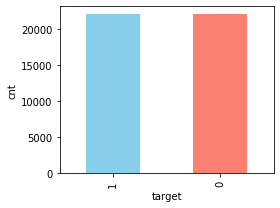

In [171]:
# '연체여부' 클래스 분포 확인
check = pd.DataFrame(y_resampled)

class_counts = check['target'].value_counts()

# Bar chart 그리기
plt.figure(figsize=(4, 3))

class_counts.plot(kind='bar', color=['skyblue', 'salmon'])

plt.xlabel('target')
plt.ylabel('cnt')

plt.tight_layout()
plt.show()


In [172]:
X_train.shape

(30809, 49)

In [173]:
y_train.shape

(30809,)

## 3. 데이터 모델링

In [174]:
#특성중요도 함수
def plot_feature_importances(model):
    n_features = X.shape[1]
    feature_importances = model.feature_importances_
    sorted_indices = np.argsort(feature_importances)[::1]  # 값에 따라 내림차순으로 정렬된 인덱스

    plt.figure(figsize=(20, 20))
    plt.barh(range(n_features), feature_importances[sorted_indices], align='center')
    plt.yticks(np.arange(n_features), X.columns[sorted_indices])
    plt.ylim(-1, n_features)

In [175]:
# 학습 곡선 함수 정의
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### 3-1. XGBoost - 최종선택

In [177]:
# XGBoost 모델 생성 및 학습
xgb_model = XGBClassifier(n_estimators=100, random_state=seed_value, enable_categorical=True)
xgb_model.fit(X_train, y_train)

#훈련세트 정확도, 테스트세트 정확도 측정
print("훈련세트 정확도 :{:.3f}".format(xgb_model.score(X_train, y_train)))
print("테스트세트 정확도 :{:.3f}".format(xgb_model.score(X_test, y_test)))

# 모델 평가
accuracy = xgb_model.score(X_test, y_test)
print(f"Accuracy on test data: {accuracy:.2f}")

ValueError: Experimental support for categorical data is not implemented for current tree method yet.

In [178]:
# Cross-validation 수행 (예: 5-fold cross-validation)
cv_scores = cross_val_score(xgb_model, X_resampled, y_resampled, cv=5, scoring=scorer)

# Cross-validation 결과 출력
print("Cross-validation 평균 정확도: {:.3f}".format(cv_scores.mean()))

Cross-validation 평균 정확도: nan


In [179]:
y_probs = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

# ROC Curve 시각화
plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

NotFittedError: need to call fit or load_model beforehand

In [180]:
y_pred = xgb_model.predict(X_test)

# F1 점수를 계산합니다.
f1 = f1_score(y_test, y_pred)
print(f1)

NotFittedError: need to call fit or load_model beforehand

In [175]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

mcc = matthews_corrcoef(y_test, y_pred)
print(mcc)

kappa = cohen_kappa_score(y_test, y_pred)
print(kappa)

[[5957  698]
 [ 241 6309]]
0.8599107201150517
0.8578503914174367


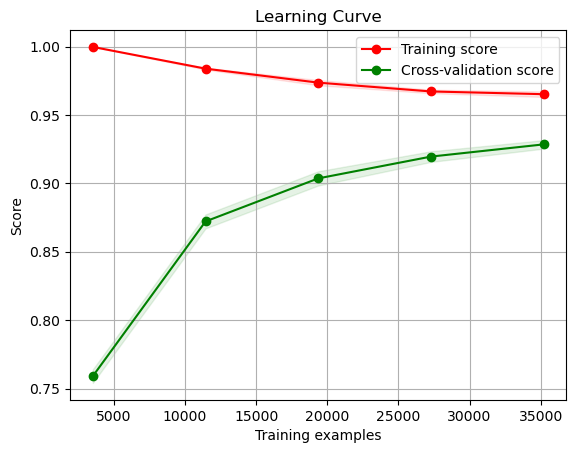

In [176]:
# 학습 곡선 그리기
plot_learning_curve(xgb_model, "Learning Curve", X_resampled, y_resampled, ylim=None, cv=5, n_jobs=-1, scoring=scorer)

plt.show()

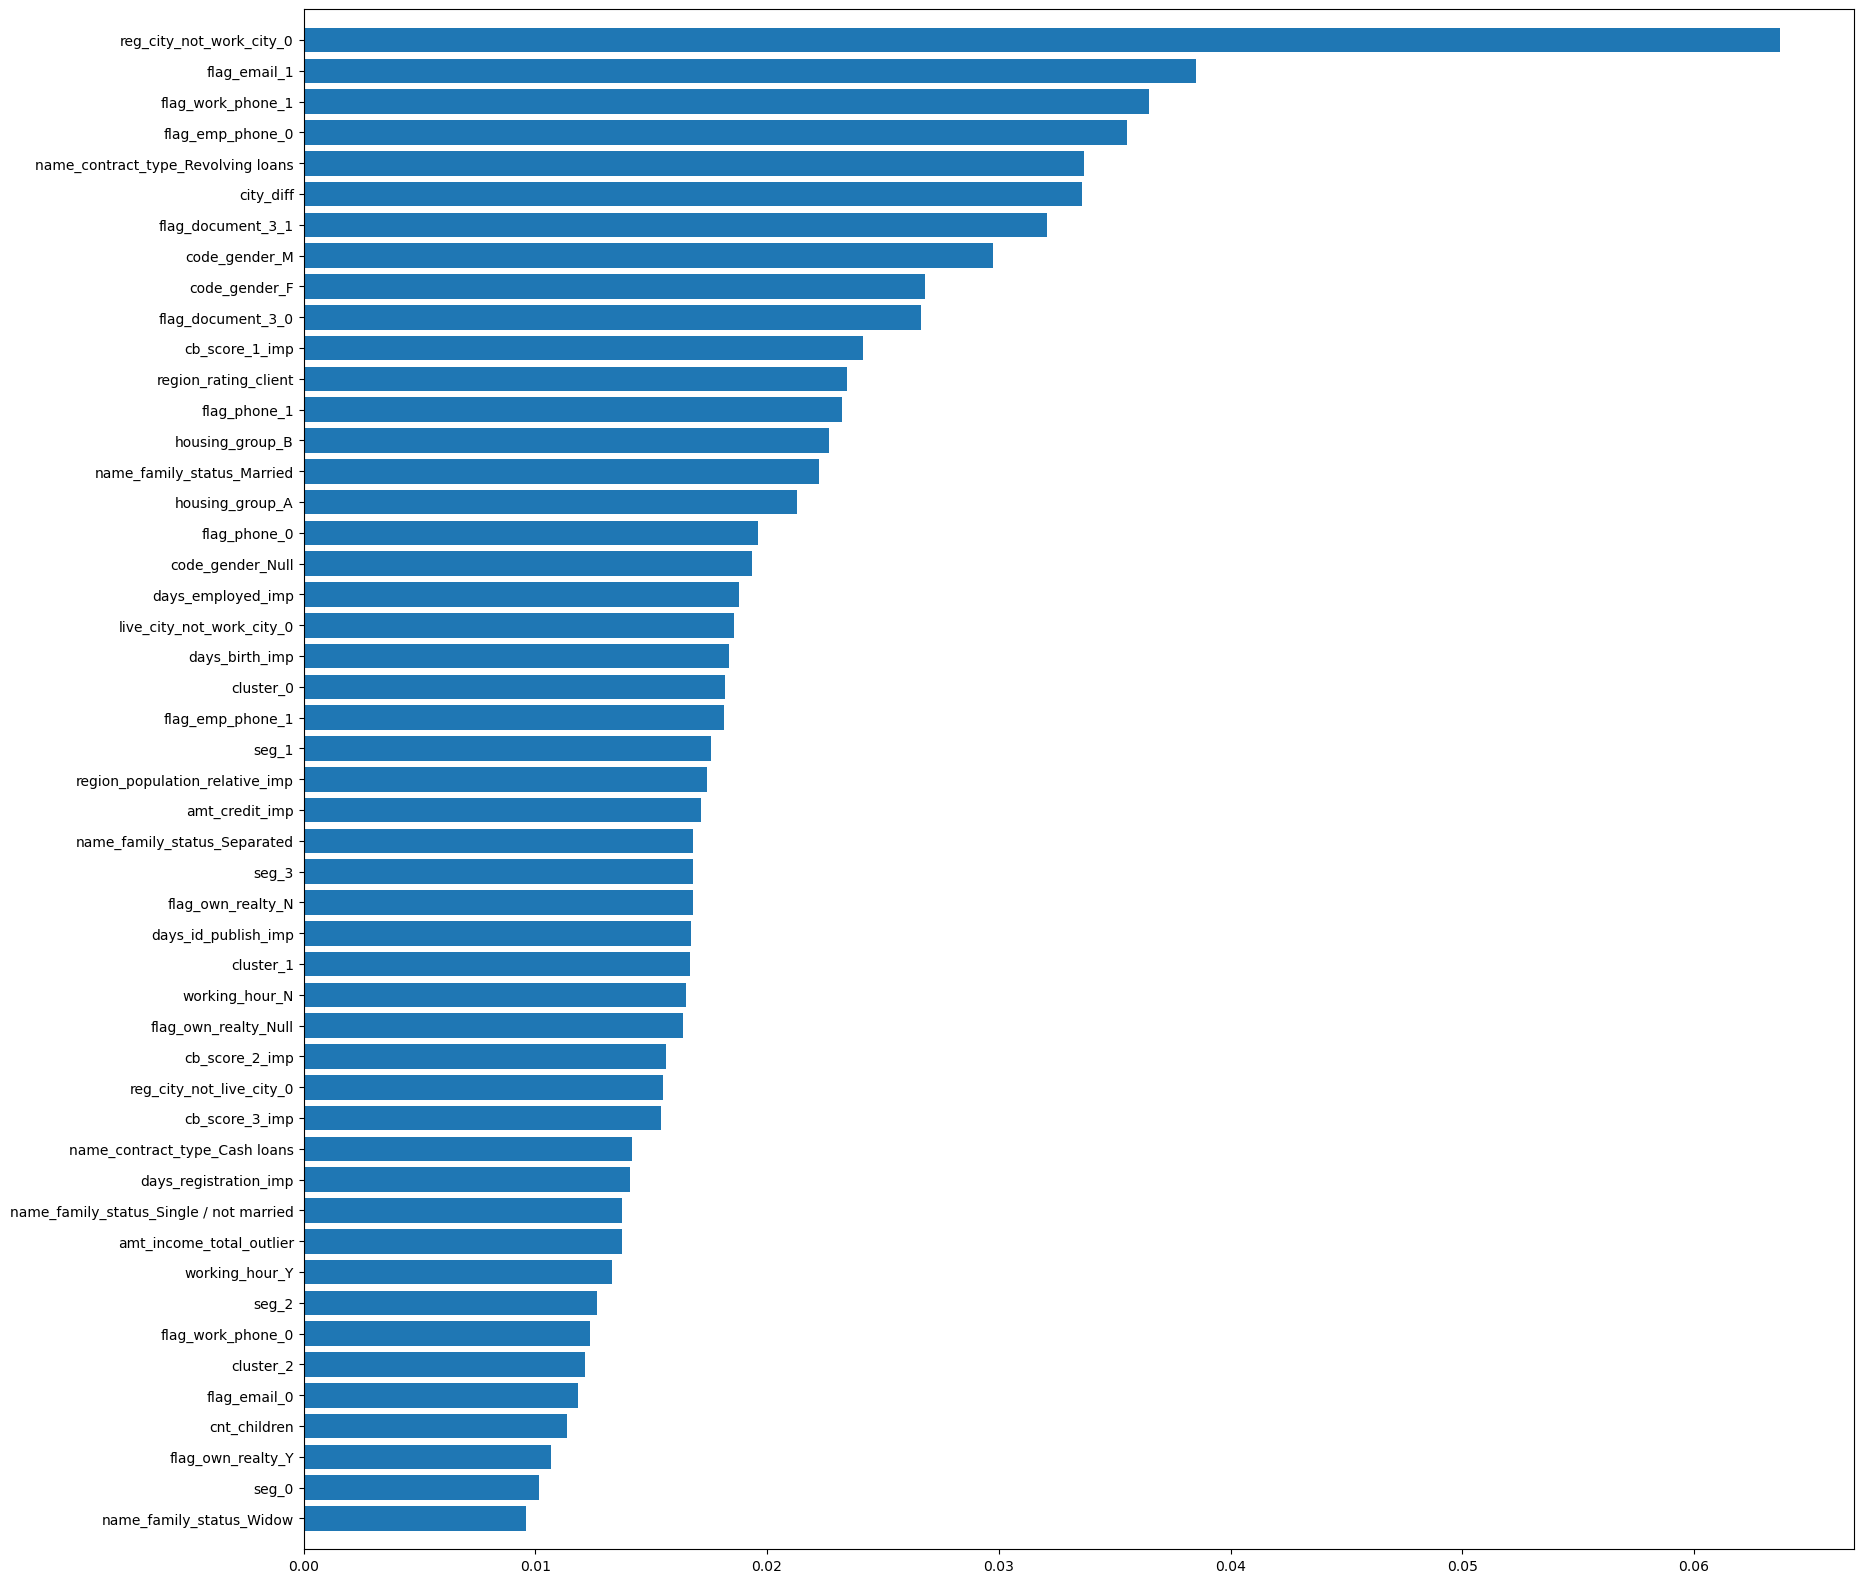

In [177]:
plot_feature_importances(xgb_model)

#### 3-1-1. SHAP

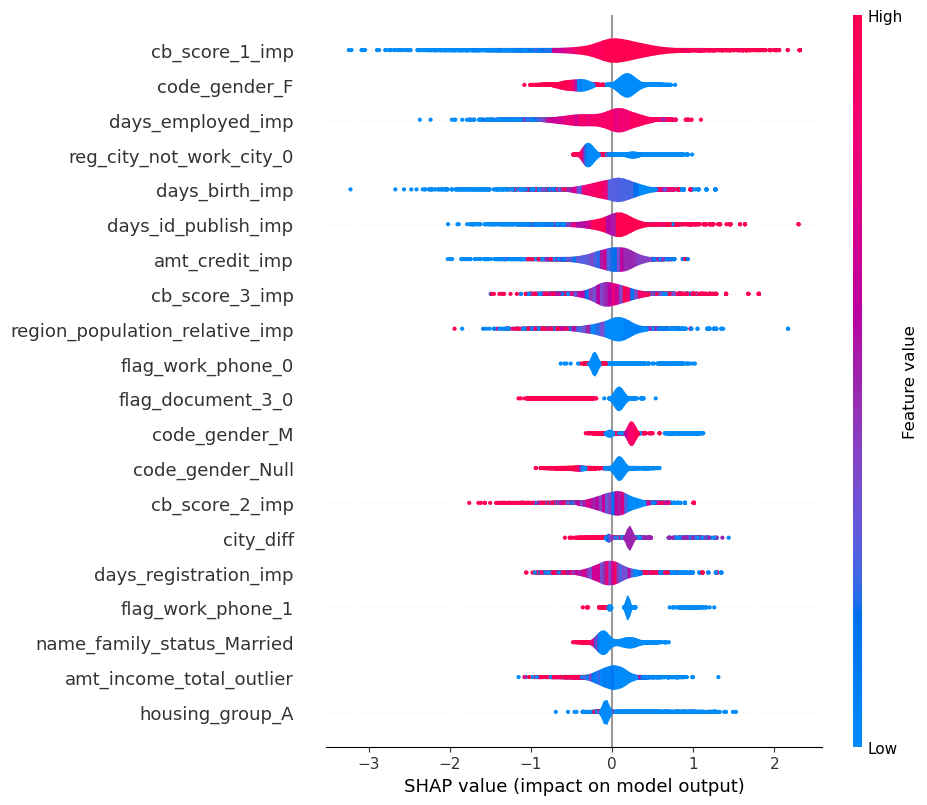

In [178]:
explainer = shap.Explainer(xgb_model)
# explainer = shap.Explainer(rf_model)

# 이전 코드에서 shap_values를 행렬로 변환합니다.
shap_values = explainer(X_test)
shap_values_matrix = shap_values.values

shap.plots.violin(shap_values)

### 3-2. Random Forest

- 성능은 좋은나, 과적합 우려로 채택하지 않음.

In [179]:
# RandomForestClassifier 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=seed_value)
rf_model.fit(X_train, y_train)

# 훈련 세트 정확도, 테스트 세트 정확도 측정
print("훈련 세트 정확도: {:.3f}".format(rf_model.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(rf_model.score(X_test, y_test)))

# 모델 평가
accuracy = rf_model.score(X_test, y_test)
print(f"Accuracy on test data: {accuracy:.2f}")

훈련 세트 정확도: 1.000
테스트 세트 정확도: 0.993
Accuracy on test data: 0.99


In [180]:
# Cross-validation 수행 (예: 5-fold cross-validation)
cv_scores = cross_val_score(rf_model, X_resampled, y_resampled, cv=5, scoring=scorer)

# Cross-validation 결과 출력
print("Cross-validation 평균 정확도: {:.3f}".format(cv_scores.mean()))

Cross-validation 평균 정확도: 0.993


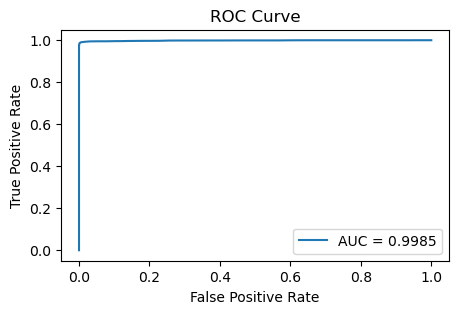

In [181]:
y_probs = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

# ROC Curve 시각화
plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [182]:
y_pred = rf_model.predict(X_test)

# F1 점수를 계산합니다.
f1 = f1_score(y_test, y_pred)
print(f1)

0.9924777402517654


In [183]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

mcc = matthews_corrcoef(y_test, y_pred)
print(mcc)

kappa = cohen_kappa_score(y_test, y_pred)
print(kappa)

[[6642   13]
 [  85 6465]]
0.9852135108057256
0.9851549116044497


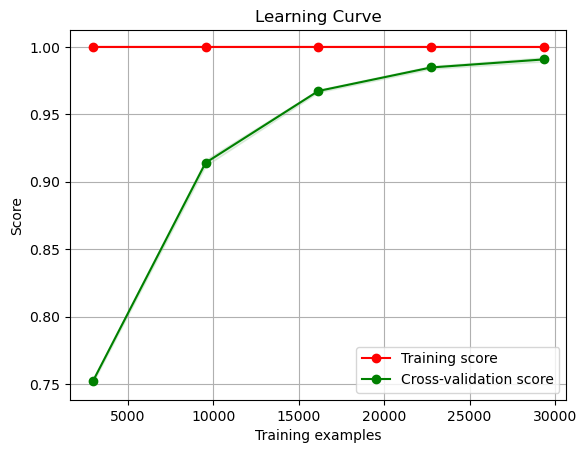

In [184]:
# 학습 곡선 그리기
plot_learning_curve(rf_model, "Learning Curve", X_resampled, y_resampled, ylim=None, cv=3, n_jobs=-1, scoring =scorer)

plt.show()

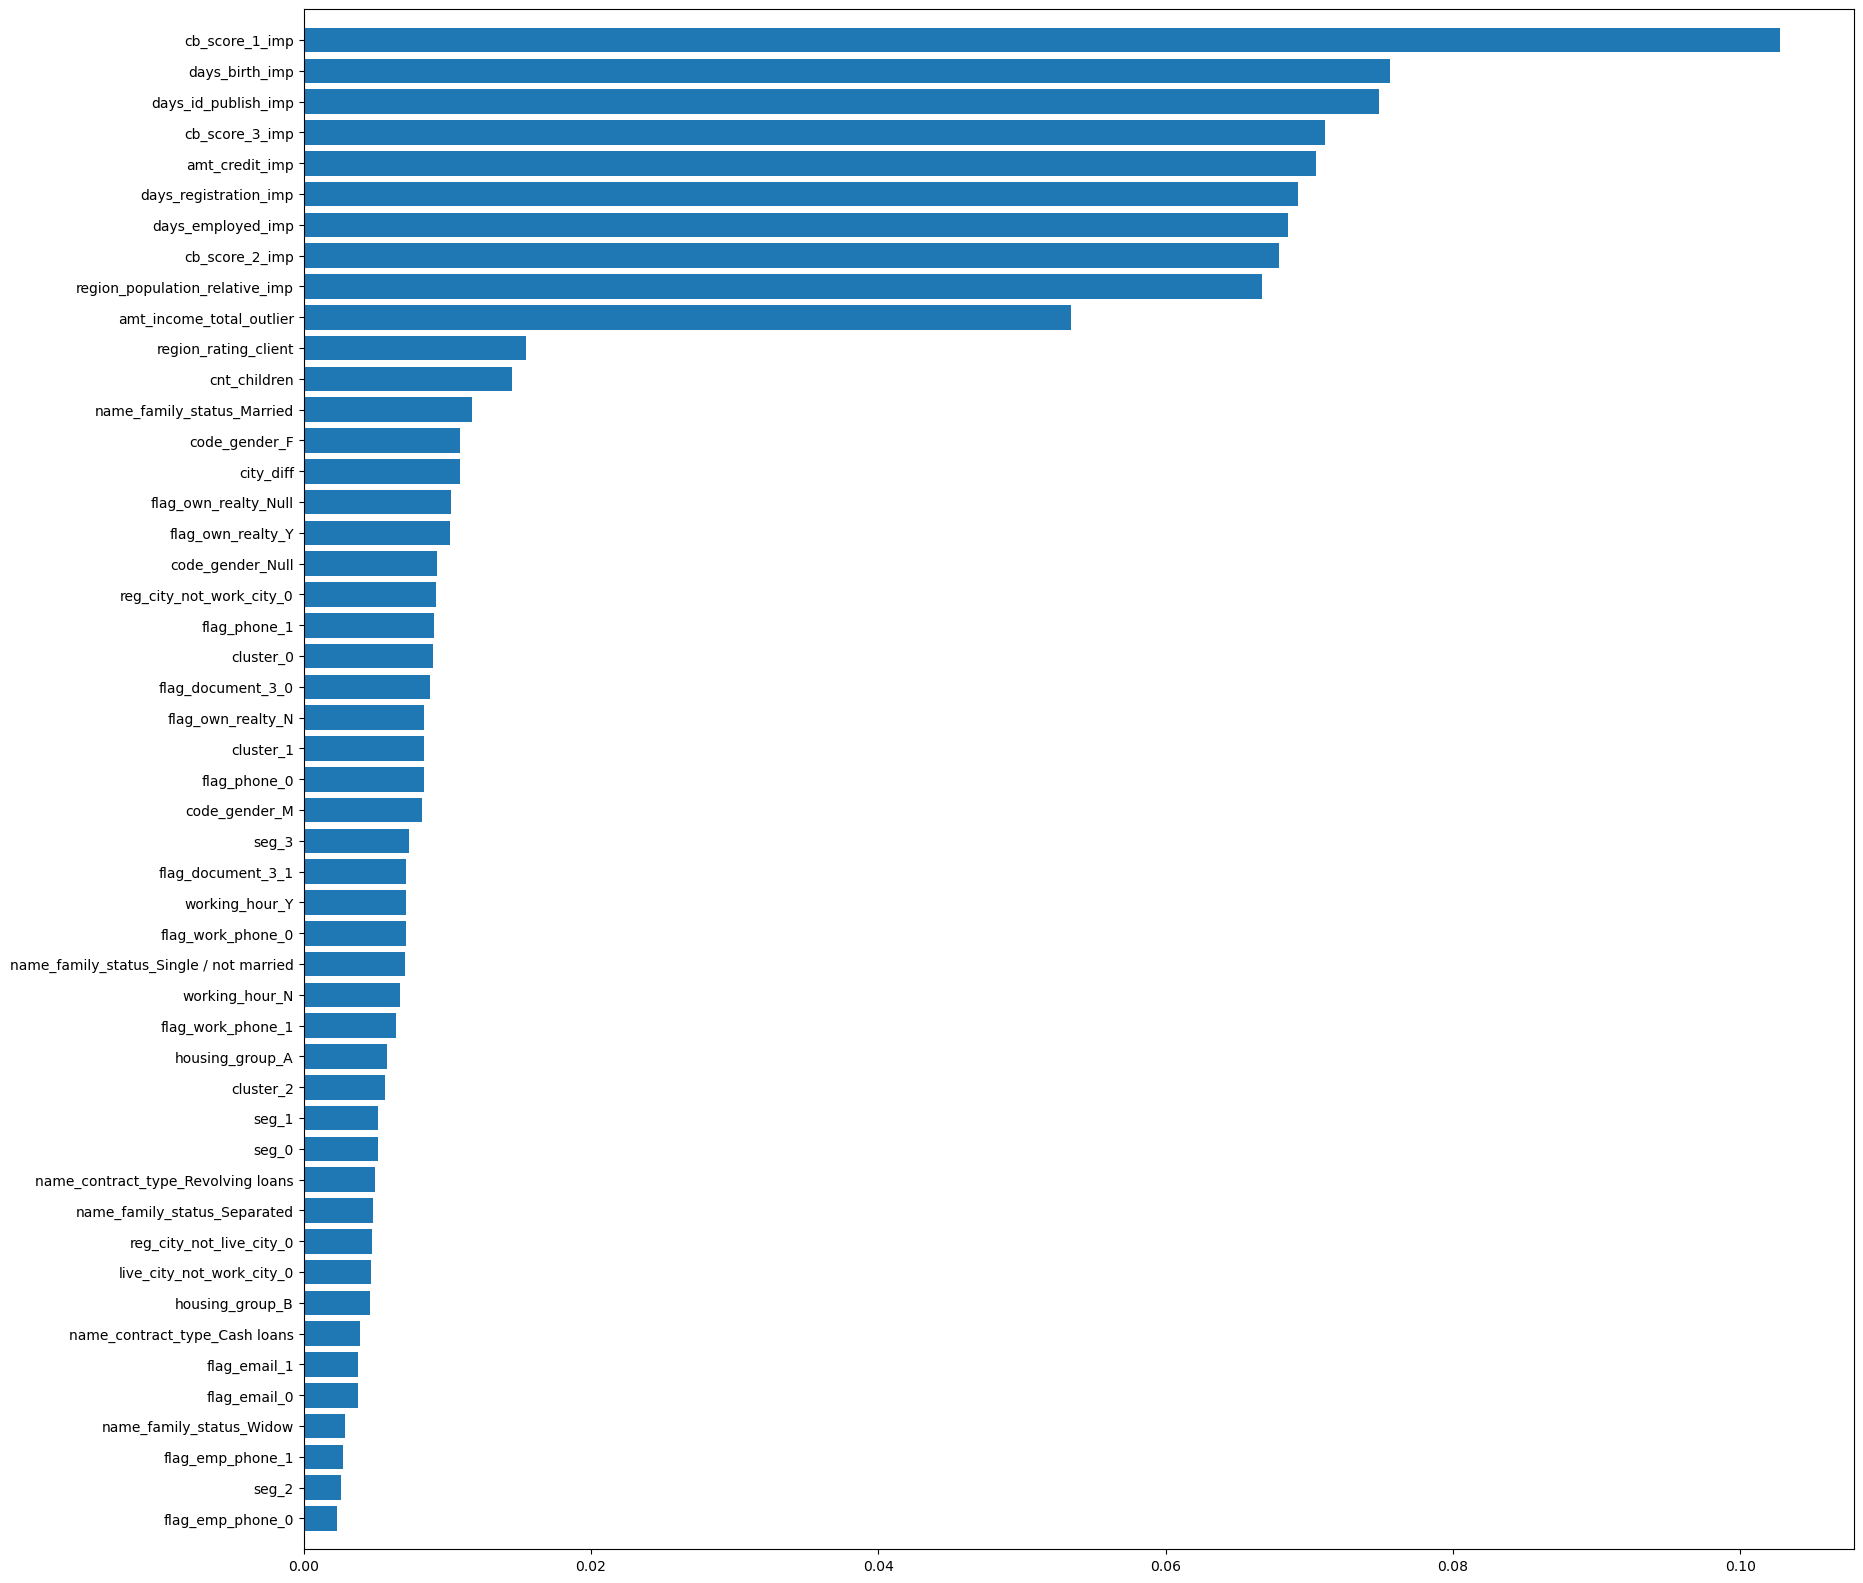

In [185]:
plot_feature_importances(rf_model)

### 3-3. Logistic Regression

- 트리기반 앙상블 모델 대비 성능이 확연히 떨어짐

In [186]:
# 로지스틱 회귀 모델 생성 및 학습
logistic_reg = LogisticRegression(random_state = seed_value)
logistic_reg.fit(X_train_s, y_train_s)

# 테스트 세트에 대한 예측
y_pred_s = logistic_reg.predict(X_test_s)

# 훈련 세트 정확도, 테스트 세트 정확도 측정
print("훈련 세트 정확도: {:.3f}".format(logistic_reg.score(X_train_s, y_train_s)))
print("테스트 세트 정확도: {:.3f}".format(logistic_reg.score(X_test_s, y_test_s)))

accuracy_s = accuracy_score(y_test_s, y_pred_s)
print(f"Accuracy on test data: {accuracy_s:.2f}")

훈련 세트 정확도: 0.638
테스트 세트 정확도: 0.638
Accuracy on test data: 0.64


In [187]:
# Cross-validation 수행 (예: 5-fold cross-validation)
cv_scores_s = cross_val_score(logistic_reg, X_resampled_s, y_resampled_s, cv=5, scoring=scorer)

# Cross-validation 결과 출력
print("Cross-validation 평균 정확도: {:.3f}".format(cv_scores_s.mean()))

Cross-validation 평균 정확도: 0.637


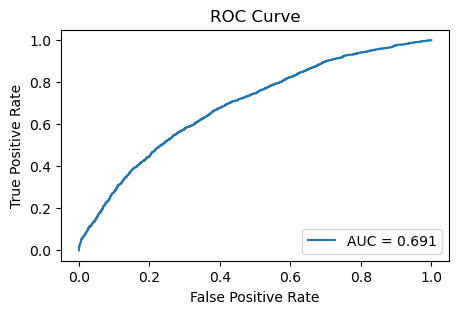

In [188]:
y_probs_s = logistic_reg.predict_proba(X_test_s)[:, 1]
fpr_s, tpr_s, __s = roc_curve(y_test_s, y_probs_s)
auc_s = roc_auc_score(y_test_s, y_probs_s)

# ROC Curve 시각화
plt.figure(figsize=(5, 3))
plt.plot(fpr_s, tpr_s, label=f"AUC = {auc_s:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [189]:
y_pred_s = logistic_reg.predict(X_test_s)

# F1 점수를 계산합니다.
f1_s = f1_score(y_test_s, y_pred_s)
print(f1_s)

0.6374260130520565


## 4. 최종 Hidden Data set에 모델 적용

### 4-1. 함수 생성

In [189]:
def pca_(df):
    
    df.rename(columns = {'year_birth' : 'year_birth_imp',
                         'year_employed' : 'year_employed_imp',
                         'year_registration' : 'year_registration_imp',
                         'year_id_publish' : 'year_id_publish_imp',
                         'cb_score_2' : 'cb_score_2_imp',
                         'amt_credit' : 'amt_credit_imp'}, inplace = True)
    
    scale_col = ['year_birth_imp', 'year_employed_imp','year_registration_imp', 'year_id_publish_imp'
             , 'cb_score_2_imp','amt_income_total_outlier','amt_credit_imp']
    
    #스케일링
    Z = df[scale_col]

    Z_scaler = StandardScaler()
    Z_scaler.fit(Z)
    Z_scaled = Z_scaler.transform(Z)

    Z_scaled_df = pd.DataFrame(Z_scaled, columns=scale_col)
    pca_cols = Z_scaled_df.copy()
    
    #범주형 변수 추가
    pca_cols['education_type'] = df['name_education_type']
    pca_cols['income_type'] = df['name_income_type']
    pca_cols['organization_type'] = df['organization_type']
    #원핫
    pca_cols = ohe(pca_cols, ['education_type','income_type', 'organization_type'])
    
    pca = PCA(n_components=0.95, random_state=seed_value)

    pca_result = pca.fit_transform(pca_cols)

    cols = []
    for i in range(pca_result.shape[1]):
        col = 'PCA_'+str(i+1)
        cols.append(col)

    pca_df = pd.DataFrame(data=pca_result, columns = cols)
    
    #클러스터링
    k = 4

    kmeans = KMeans(n_clusters=k, random_state=seed_value)
    kmeans.fit(pca_df.iloc[:,:6])
    labels = kmeans.predict(pca_df.iloc[:,:6])
    knn_pca_df = pd.DataFrame(pca_df.iloc[:,:6])
    knn_pca_df.loc[:,'label'] = labels

    df['seg'] = knn_pca_df['label']

In [190]:
def org_kmeans(df):
    
    df.rename(columns = {'days_birth' : 'days_birth_imp',
                         'days_employed' : 'days_employed_imp',
                         'days_registration' : 'days_registration_imp',
                         'days_id_publish' : 'days_id_publish_imp',
                         'region_population_relative' : 'region_population_relative_imp'}, inplace = True)
    
    
    selected_columns = ['amt_income_total_outlier', 'amt_credit_imp', 'region_population_relative_imp', 'days_birth_imp',
                    'days_employed_imp', 'days_registration_imp', 'days_id_publish_imp', 'cb_score_1_imp',
                    'cb_score_2_imp', 'cb_score_3_imp']

    selected_data = df[selected_columns]
    
    #scailing
    scaler = StandardScaler()

    standardized_data = scaler.fit_transform(selected_data)
    standardized_df = pd.DataFrame(standardized_data, columns=selected_columns)
    
    #encoding
    standardized_df['organization_type_encoded'] = label_encoder.fit_transform(df['organization_type'])	
    
    #K-means
    k = 3

    kmeans = KMeans(n_clusters=k, random_state=seed_value)
    kmeans.fit(standardized_df)
    wcss_values.append(kmeans.inertia_)
    labels = kmeans.predict(standardized_df)
    
    standardized_df['cluster'] = labels    
#     standardized_df['cluster'] = standardized_df['cluster'].astype(object)
    
    df['cluster'] = standardized_df['cluster']

### 4-2. 데이터 불러오기

hidden data의 파일명을 'hidden_dataset.csv'라 가정함.

In [ ]:
test_df = pd.read_csv('hidden_dataset.csv')

### 4-3. 전처리 및 모델링

In [ ]:
type_change(test_df)   #데이터타입변경
col_to_lower(test_df)  #컬럼명소문자로 변경

In [ ]:
#소득금액 이상치 처리
numeric_outlier(test_df, 'amt_income_total')


#연수 변수 생성
transform_and_divide_continuous_variable(test_df, 'days_birth')
transform_and_divide_continuous_variable(test_df, 'days_employed')
transform_and_divide_continuous_variable(test_df, 'days_registration')
transform_and_divide_continuous_variable(test_df, 'days_id_publish')

new_column_names = {
    'days_birth_y': 'year_birth',
    'days_employed_y': 'year_employed',
    'days_registration_y': 'year_registration',
    'days_id_publish_y': 'year_id_publish'
}
test_df.rename(columns=new_column_names, inplace=True)


#범주형변수의 XNA값 처리
cat_null(test_df, 'code_gender')
cat_null(test_df, 'flag_own_realty')

#city_diff 파생변수 생성
test_df['city_diff'] = test_df[['reg_city_not_live_city', 'reg_city_not_work_city', 'live_city_not_work_city']].eq(1).sum(axis=1)

# housing_group
test_df['housing_group'] = test_df['name_housing_type'].map(housing_group_mapping)

# working_hour
test_df['working_hour'] = test_df['hour_appr_process_start'].apply(lambda x: 'Y' if x <= 18 and x >= 9 else 'N')

# 자녀유무, 연금수령자 컬럼생성
test_df['child_yn'] = test_df['cnt_children'].apply(lambda x: 'Y' if x > 0 else 'N')
test_df['is_pensioner'] = test_df['name_income_type'].apply(lambda x: 'Y' if x == 'Pensioner' else 'N')

test_df = ohe(test_df, ['child_yn','is_pensioner'])

# PCA + K-means
# 테스트 데이터의 연속형 변수에는 결측처리가 되어있다고 가정하고, 컬럼명만 변경함
pca_(test_df)
test_df['seg'].fillna(0, inplace = True)
test_df['seg'] = test_df['seg'].astype('int')
test_df = ohe(test_df, 'seg')

#근무지 K-means
#변수명 변경
test_df.rename(columns = {'cb_score_1' : 'cb_score_1_imp',
                         'cb_score_3' : 'cb_score_3_imp'}, inplace = True)
org_kmeans(test_df)
test_df['cluster'].fillna(0, inplace = True)
test_df['cluster'] = test_df['cluster'].astype('int')
test_df = ohe(test_df, 'cluster')

#onehot encoding
test_df = ohe(test_df, ['code_gender','flag_own_realty', 'flag_document_3','flag_emp_phone','flag_work_phone', 'flag_phone', 'flag_email'
                     , 'reg_city_not_live_city','reg_city_not_work_city','live_city_not_work_city'
                     , 'name_contract_type', 'name_family_status'
                     , 'housing_group', 'working_hour'])

In [ ]:
#최종 변수 선택
test_df = test_df[['sk_id_curr', 'cnt_children', 'amt_income_total_outlier', 
                   'region_rating_client', 'region_population_relative_imp',
                   'flag_document_3_0', 'flag_document_3_1',
                   'flag_emp_phone_0', 'flag_emp_phone_1',
                   'flag_work_phone_0', 'flag_work_phone_1',
                   'flag_phone_0', 'flag_phone_1',
                   'flag_email_0','flag_email_1',
                   'code_gender_Null','code_gender_F', 'code_gender_M',
                   'city_diff','reg_city_not_live_city_0','reg_city_not_work_city_0','live_city_not_work_city_0',
                   'flag_own_realty_Null', 'flag_own_realty_N', 'flag_own_realty_Y',
                   'name_contract_type_Cash loans', 'name_contract_type_Revolving loans',
                   'name_family_status_Married', 'name_family_status_Separated',
                   'name_family_status_Single / not married',
                   'name_family_status_Widow',
                   'housing_group_A','housing_group_B',
                   'working_hour_N','working_hour_Y', 
                   'days_birth_imp','days_employed_imp', 'days_registration_imp', 'days_id_publish_imp',
                   'cb_score_2_imp', 'cb_score_1_imp', 'cb_score_3_imp',
                   'amt_credit_imp',
                   'seg_0', 'seg_1', 'seg_2', 'seg_3',
                   'cluster_0', 'cluster_1','cluster_2', 
                   'target']]

In [ ]:
# X,y split
X_hidden = test_df.drop(['sk_id_curr','target'],axis = 1)
y_hidden = test_df['target']

obj_cols = X_hidden.select_dtypes('object').columns
X_hidden[obj_cols] = X_hidden[obj_cols].astype('int')

#모델 적용
y_probs_hidden = xgb_model.predict_proba(X_hidden)[:, 1]
fpr_hidden, tpr_hidden, thresholds_hidden = roc_curve(y_hidden, y_probs_hidden)
auc_hidden = roc_auc_score(y_hidden, y_probs_hidden)

y_pred_hidden = xgb_model.predict(X_hidden)

In [ ]:
# ROC Curve 시각화
plt.figure(figsize=(5, 3))
plt.plot(fpr_hidden, tpr_hidden, label=f"AUC = {auc_hidden:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()